In [1]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Our algorithms, by from the easiest to the hardest to intepret.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Pre-processing

## Data Cleansing

### Load dataset

In [2]:
df = pd.read_csv('BankCustomerData.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,term_deposit
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42639 entries, 0 to 42638
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   age           42639 non-null  int64 
 1   job           42639 non-null  object
 2   marital       42639 non-null  object
 3   education     42639 non-null  object
 4   default       42639 non-null  object
 5   balance       42639 non-null  int64 
 6   housing       42639 non-null  object
 7   loan          42639 non-null  object
 8   contact       42639 non-null  object
 9   day           42639 non-null  int64 
 10  month         42639 non-null  object
 11  duration      42639 non-null  int64 
 12  campaign      42639 non-null  int64 
 13  pdays         42639 non-null  int64 
 14  previous      42639 non-null  int64 
 15  poutcome      42639 non-null  object
 16  term_deposit  42639 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.5+ MB


* Target klasifikasi adalah `term_deposit`

### Missing Value

In [4]:
df.isna().sum()

age             0
job             0
marital         0
education       0
default         0
balance         0
housing         0
loan            0
contact         0
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome        0
term_deposit    0
dtype: int64

* Tidak terdapat missing value

### Outlier

cek outlier dengan melihat data describe

In [5]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,42639.000000,42639.000000,42639.000000,42639.000000,42639.000000,42639.000000,42639.000000
mean,40.788808,1331.863951,15.854781,255.957504,2.816412,34.169141,0.465442
std,10.200236,3011.537676,8.293901,258.361368,3.163564,92.041713,2.166705
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,62.000000,8.000000,101.000000,1.000000,-1.000000,0.000000
50%,39.000000,429.000000,16.000000,177.000000,2.000000,-1.000000,0.000000
75%,48.000000,1381.500000,21.000000,315.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,536.000000,275.000000


In [6]:
numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
nums  = df.select_dtypes(include = numerics).columns
kategoris = ['object']
cats = df.select_dtypes(include = kategoris).columns

cek outlier dengan melihat data describe

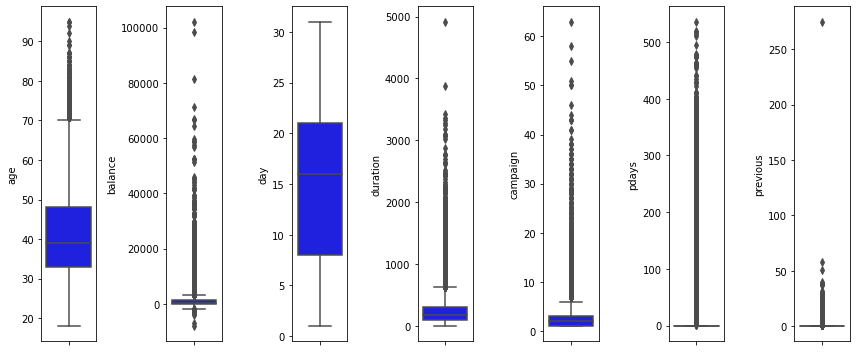

In [7]:
plt.figure(figsize=(12, 5))
for i in range(0, len(nums)):
    plt.subplot(1, len(nums), i+1)
    sns.boxplot(y=df[nums[i]], color='blue', orient='v')
    plt.tight_layout()

* Berdasarkan describe data dan boxplot, outlier terlihat pada semua features, kecuali `day`
* Treatment drop outlier hanya dilakukan pada feature `campaign`. Karena untuk data numeric akan dilakukan proses grouping. Dan Performa model paling bagus ketika dilakukan drop outlier pada feature `campaign`

#### Drop Outlier

Drop Outlier dengan IQR

In [8]:
print(f'Jumlah baris sebelum memfilter outlier: {len(df)}')

filtered_entries = np.array([True] * len(df))
for col in ['campaign']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low_limit = Q1 - (IQR * 1.5)
    high_limit = Q3 + (IQR * 1.5)

    filtered_entries = ((df[col] >= low_limit) & (df[col] <= high_limit)) & filtered_entries
    
df = df[filtered_entries]

print(f'Jumlah baris setelah memfilter outlier: {len(df)}')

Jumlah baris sebelum memfilter outlier: 42639
Jumlah baris setelah memfilter outlier: 39618


### Duplicated Values

In [9]:
df = df.drop_duplicates()
df.shape

(39618, 17)

* Tidak terdapat duplicated values, jumlah baris masih sama dengan yang sebelumnya yaitu 39618.

## Feature engineering

### Data Numeric menjadi Categorical

* Perubahan data numeric menjadi categorical agar mempermudah proses analisa dan meningkatkan peformance model
* Sebelumnya sudah dilakukan percobaan model kondisi data numeric dengan dan tanpa treatment categorical, performance model (AUC/Recall/Precision) lebih tinggi pada model yang sebelumnya dilakukan treatment pada data numeric menjadi categorical

#### Age

In [10]:
def umur(x): 
    if x['age'] <= 24: 
        result = 'Youth: <=24' 
    elif x['age'] >24 and x['age'] <= 29: 
        result = 'Adult_1: 25-29' 
    elif x['age'] >29 and x['age'] <= 34: 
        result = 'Adult_2: 30-34'     
    elif x['age'] >34 and x['age'] <= 39: 
        result = 'Adult_3: 35-39' 
    elif x['age'] >39 and x['age'] <= 44: 
        result = 'Adult_4: 40-44'        
    elif x['age'] >44 and x['age'] <= 49: 
        result = 'Adult_5: 45-49'        
    elif x['age'] >49 and x['age'] <= 54:
         result = 'Adult_6: 50-54'       
    elif x['age'] >54 and x['age'] <= 59:
         result = 'Adult_7: 55 -59'
    elif x['age'] >59 and x['age'] <= 64:
         result = 'Adult_8: 60 -64'
    elif x['age'] >64:
         result = 'Senior: >=65'
    return result

df['age_cat'] = df.apply(lambda x : umur(x), axis =1)

In [11]:
df['age_cat'].value_counts()

Adult_2: 30-34     8605
Adult_3: 35-39     7368
Adult_4: 40-44     5573
Adult_5: 45-49     4855
Adult_6: 50-54     3988
Adult_1: 25-29     3860
Adult_7: 55 -59    3515
Adult_8: 60 -64     724
Youth: <=24         646
Senior: >=65        484
Name: age_cat, dtype: int64

#### Balance

Grouping dilakukan berdasarkan percentile

In [12]:
df.describe(percentiles=[0.2,0.4,0.6,0.8])

,age,balance,day,duration,campaign,pdays,previous
count,39618.000000,39618.000000,39618.000000,39618.000000,39618.000000,39618.000000,39618.000000
mean,40.765763,1336.687743,15.551290,261.362007,2.152077,35.690368,0.477636
std,10.246982,3014.550414,8.218294,258.671154,1.324296,93.587313,2.185902
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
20%,32.000000,19.000000,7.000000,92.000000,1.000000,-1.000000,0.000000
40%,36.000000,260.800000,13.000000,149.000000,1.000000,-1.000000,0.000000
50%,39.000000,434.000000,16.000000,182.000000,2.000000,-1.000000,0.000000
60%,42.000000,680.000000,18.000000,224.000000,2.000000,-1.000000,0.000000
80%,50.000000,1815.000000,23.000000,370.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,6.000000,536.000000,275.000000


Balance Categorical:
1. Balance <= Percentile 20
2. Percentile 20 < Balance <= Percentile 40
3. Percentile 40 < Balance <= Percentile 60
4. Percentile 60 < Balance <= Percentile 80
5. Balance > Percentile 80

In [13]:
def balance(x):
    if x['balance'] <= 19:
        result = 1
    elif x['balance'] >19 and x['balance'] <= 260.8:
        result = 2
    elif x['balance'] >260.8 and x['balance'] <= 680:
        result = 3
    elif x['balance'] > 680 and x['balance'] <= 1815:
        result = 4
    else:
        result = 5
    return result

df['balance_cat'] = df.apply(lambda x : balance(x), axis =1)

In [14]:
df['balance_cat'].value_counts()

1    7972
3    7928
5    7922
4    7921
2    7875
Name: balance_cat, dtype: int64

#### day

Day digrouping per week

In [15]:
def day_cat(x):
    if x['day']  <= 7:
        result = 1
    elif x['day'] >= 8 and x['day'] <= 14:
        result = 2
    elif x['day'] >= 15 and x['day'] <= 21:
        result = 3
    elif x['day'] >= 22:
        result = 4
    return result

df['day_cat'] = df.apply(lambda x : day_cat(x), axis =1)

In [16]:
df['day_cat'].value_counts()

3    12497
2     9289
4     8986
1     8846
Name: day_cat, dtype: int64

#### pday

Pdays digrouping per bulan

In [17]:
df['pdays'].value_counts()

-1      33243
 370       96
 364       75
 350       68
 183       65
        ...  
 47         1
 383        1
 495        1
 401        1
 32         1
Name: pdays, Length: 417, dtype: int64

In [18]:
def pdyas(x):
    if x['pdays'] <1:
        result = 0
    elif x['pdays'] >= 1 and x['pdays'] <= 30:
        result = 1
    elif x['pdays'] >= 31 and x['pdays'] <= 60:
        result = 2
    elif x['pdays'] >= 61 and x['pdays'] <= 120:
        result = 3 
    elif x['pdays'] >= 121 and x['pdays'] <= 150:
        result = 4
    elif x['pdays'] >= 151 and x['pdays'] <= 180:
        result = 5 
    elif x['pdays'] >= 181 and x['pdays'] <= 210:
        result = 6       
    elif x['pdays'] >= 211 and x['pdays'] <= 240:
        result = 7 
    elif x['pdays'] >= 241 and x['pdays'] <= 270:
        result = 8
    elif x['pdays'] >= 271 and x['pdays'] <= 300:
        result = 9
    elif x['pdays'] >= 301 and x['pdays'] <= 330:
        result = 10
    elif x['pdays'] >= 331 and x['pdays'] <= 360:
        result = 11
    else:
        result = 12
    return result

df['pdyas_new'] = df.apply(lambda x : pdyas(x), axis =1)

In [19]:
df['pdyas_new'].value_counts()

0     33243
3      1091
11     1026
6       738
5       714
12      598
8       573
10      442
9       413
4       381
7       168
1       155
2        76
Name: pdyas_new, dtype: int64

#### Campaign

In [20]:
df['campaign'].value_counts()

1    16143
2    11877
3     5246
4     3388
5     1710
6     1254
Name: campaign, dtype: int64

In [21]:
def campaign_cat(x):
    if x['campaign'] ==1:
        result = 'sekali'
    elif x['campaign'] >1 and x['campaign'] <= 3:
        result = 'jarang'
    elif x['campaign'] >= 4 and x['campaign'] <= 5:
        result = 'sering'  
    else:
        result = 'sangat_sering'
    return result

df['campaign_cat'] = df.apply(lambda x : campaign_cat(x), axis =1)

In [22]:
df['campaign_cat'].value_counts()

jarang           17123
sekali           16143
sering            5098
sangat_sering     1254
Name: campaign_cat, dtype: int64

### Features yang di drop / tidak digunakan

`duration` : Info Duration didapatkan setelah campaign, sehingga tidak bisa digunakan untuk model
`default` : Data Default memiliki proporsi yes dan no yang terlalu jamping, sehingga tidak digunakan (sudah dilakukan percobaan pada model dengan atau tanpa feature default, tidak memiliki perbedaan pada performance model
`previous` : Info yang diberikan berkorelasi tinggi dengan campaign (informasi yang diberikan mirip)

campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
previous: number of contacts performed before this campaign and for this client (numeric)

### Data Invalid

JIka dicek terdapat data invalid pada pdays dan campaign

In [23]:
pd.crosstab(df['pdays'], df.campaign_cat)

campaign_cat,jarang,sangat_sering,sekali,sering
pdays,,,,
-1,14554,1118,13035,4536
1,1,0,2,0
2,16,0,19,0
4,0,0,1,0
5,8,0,3,0
...,...,...,...,...
495,0,0,1,0
515,0,0,1,0
518,0,0,1,0


Revisi pdays_new

In [24]:
def pdays(x):
    if x['campaign'] ==1 and x['pdyas_new'] >0:
        result = 1
    else:
        result = x['pdyas_new']
    return result

df['pdays_rev'] = df.apply(lambda x : pdays(x), axis =1)

In [25]:
df['pdays_rev'].value_counts()

0     33243
1      3191
11      556
3       484
5       374
6       360
12      326
8       303
10      236
9       231
4       189
7       104
2        21
Name: pdays_rev, dtype: int64

Revisi campaign_cat

In [26]:
def campaign_rev(x):
    if x['pdays_rev'] ==0 and x['campaign_cat'] != 'sekali':
        result = 'sekali'
    else:
        result = x['campaign_cat']
    return result

df['campaign_rev'] = df.apply(lambda x : campaign_rev(x), axis =1)

In [27]:
df['campaign_rev'].value_counts()

sekali           36351
jarang            2569
sering             562
sangat_sering      136
Name: campaign_rev, dtype: int64

In [28]:
pd.crosstab(df['pdays_rev'], df.campaign_rev)

campaign_rev,jarang,sangat_sering,sekali,sering
pdays_rev,,,,
0,0,0,33243,0
1,65,3,3108,15
2,17,1,0,3
3,403,16,0,65
4,160,3,0,26
5,275,26,0,73
6,284,15,0,61
7,87,4,0,13
8,241,13,0,49


Masih terdapat data invalid dimana pdays_rev 1 namun campaignnya pada category sekali. Yang seharusnya pada kategori jarang (>1). Sehingga dilakukan penyesuaian data

In [29]:
def campaign_rev(x):
    if x['pdays_rev'] ==1 and x['campaign_cat'] == 'sekali':
        result = 'jarang'
    else:
        result = x['campaign_rev']
    return result

df['campaign_rev'] = df.apply(lambda x : campaign_rev(x), axis =1)

In [30]:
pd.crosstab(df['pdays_rev'], df.campaign_rev)

campaign_rev,jarang,sangat_sering,sekali,sering
pdays_rev,,,,
0,0,0,33243,0
1,3173,3,0,15
2,17,1,0,3
3,403,16,0,65
4,160,3,0,26
5,275,26,0,73
6,284,15,0,61
7,87,4,0,13
8,241,13,0,49


# EDA & Insights

In [31]:
df2 = df.copy()


In [32]:
def td(x):
    if x['term_deposit'] == 'yes':
        data = 1
    else:
        data = 0
    return data

df2['term_deposit_num'] = df2.apply(lambda x: td(x), axis =1)

<AxesSubplot:>

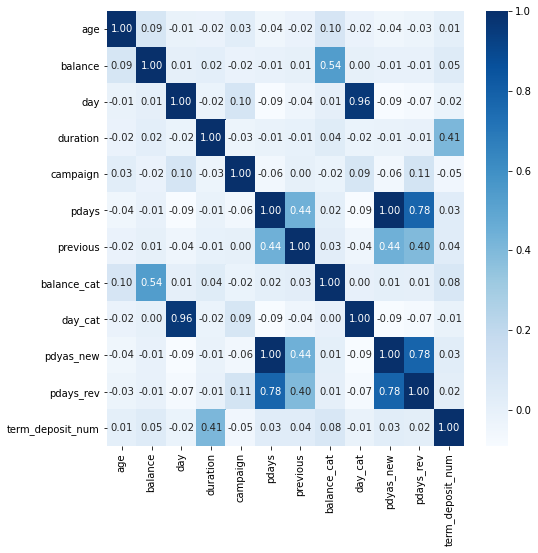

In [33]:
plt.figure(figsize=(8, 8))
sns.heatmap(df2.corr(), cmap='Blues', annot=True, fmt='.2f')

Jika dilihat dari heatmap, feature dengan korelasi paling tinggi adalah balance_cat 0.8. Duration dibaikan karena tidak digunakan untuk pemodelan.

## Age

In [34]:
df['age_cat'].value_counts()

Adult_2: 30-34     8605
Adult_3: 35-39     7368
Adult_4: 40-44     5573
Adult_5: 45-49     4855
Adult_6: 50-54     3988
Adult_1: 25-29     3860
Adult_7: 55 -59    3515
Adult_8: 60 -64     724
Youth: <=24         646
Senior: >=65        484
Name: age_cat, dtype: int64

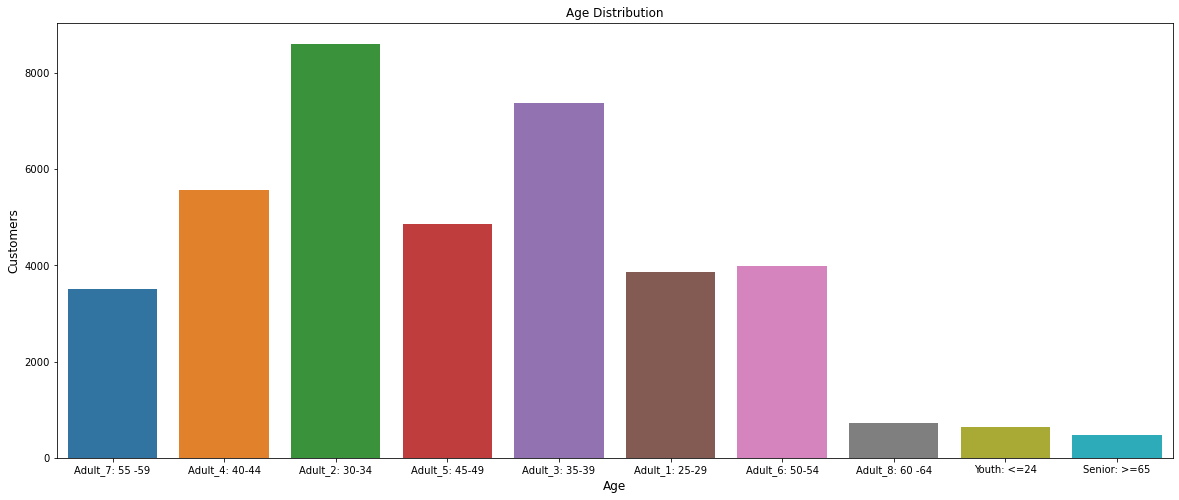

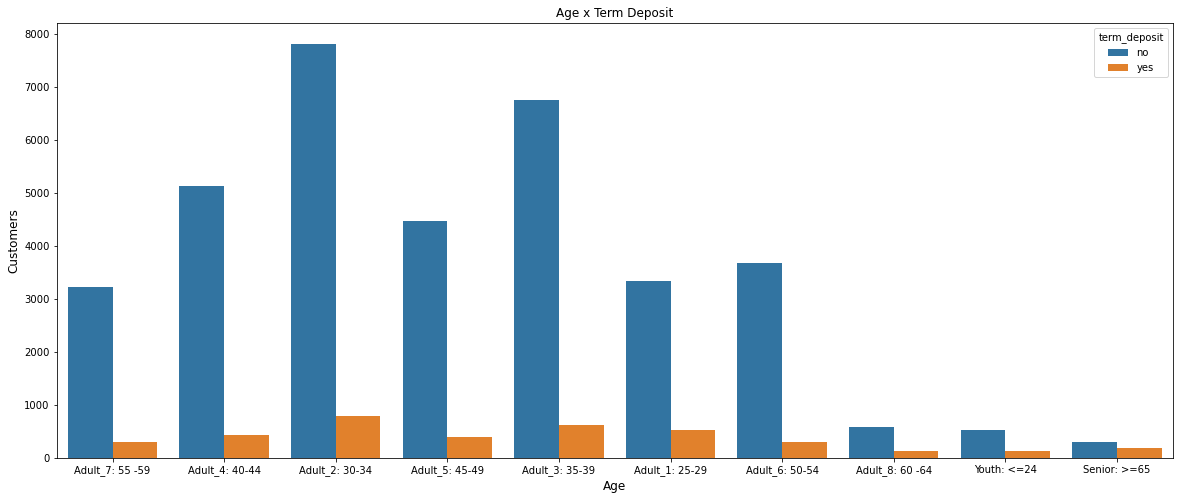

<Figure size 1440x576 with 0 Axes>

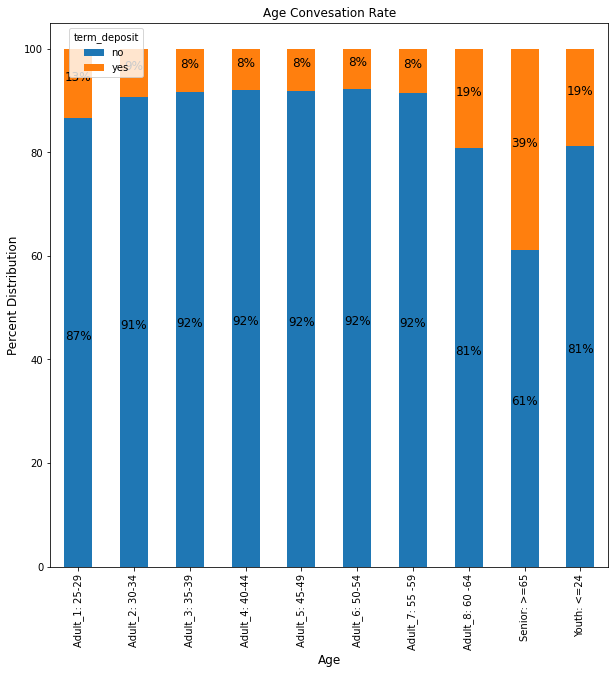

In [35]:
### Distribusi value pada feature Age
plt.figure(figsize=(20,8))
sns.countplot(x= df['age_cat'], data=df)
plt.xlabel('Age',fontsize = 12)
plt.ylabel('Customers',fontsize = 12)
plt.title("Age Distribution")

### Age x Term Deposit (Count)
plt.figure(figsize=(20,8))
sns.countplot(x= df['age_cat'], data=df, hue='term_deposit')
plt.xlabel('Age',fontsize = 12)
plt.ylabel('Customers',fontsize = 12)
plt.title("Age x Term Deposit")

### Age Convesation Rate (%)
plt.figure(figsize=(20,8))

pal = ["royalblue", "dodgerblue"]
ax= pd.crosstab(df['age_cat'], df['term_deposit']).apply(lambda r: r/r.sum()*100, axis=1)
ax_1 = ax.plot.bar(figsize=(10,10),stacked=True, rot=0)

plt.legend(loc='upper center', bbox_to_anchor=(0.1, 1.0), title="term_deposit")

plt.xlabel('Age',fontsize = 12)
plt.ylabel('Percent Distribution',fontsize = 12)
plt.title("Age Convesation Rate")
locs, labels = plt.xticks() #rotate label x axis
plt.setp(labels, rotation=90)

for rec in ax_1.patches:
    height = rec.get_height()
    ax_1.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom',
             fontsize = 12)
plt.show()

### Conclucion

In [36]:
age_cat = pd.crosstab(df['age_cat'], df.term_deposit)
age_cat ['total_data'] = (age_cat['no'] + age_cat['yes'])
age_cat ['conversation_rate'] = age_cat['yes']/(age_cat['no'] + age_cat['yes'])
age_cat ['%conversation'] = age_cat['yes']/sum(age_cat['yes'])
age_cat.sort_values(['%conversation'], ascending = False)

term_deposit,no,yes,total_data,conversation_rate,%conversation
age_cat,,,,,
Adult_2: 30-34,7809,796,8605,0.092504,0.208595
Adult_3: 35-39,6748,620,7368,0.084148,0.162474
Adult_1: 25-29,3343,517,3860,0.133938,0.135482
Adult_4: 40-44,5132,441,5573,0.079132,0.115566
Adult_5: 45-49,4464,391,4855,0.080536,0.102463
Adult_6: 50-54,3682,306,3988,0.076730,0.080189
Adult_7: 55 -59,3218,297,3515,0.084495,0.077830
Senior: >=65,296,188,484,0.388430,0.049266
Adult_8: 60 -64,585,139,724,0.191989,0.036426


## Balance

In [37]:
df['balance_cat'].value_counts()

1    7972
3    7928
5    7922
4    7921
2    7875
Name: balance_cat, dtype: int64

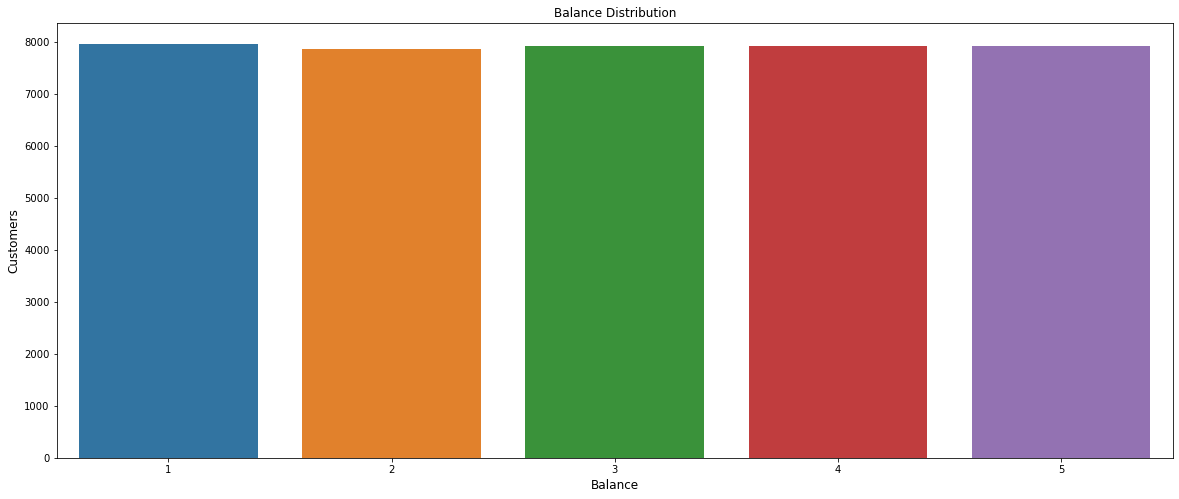

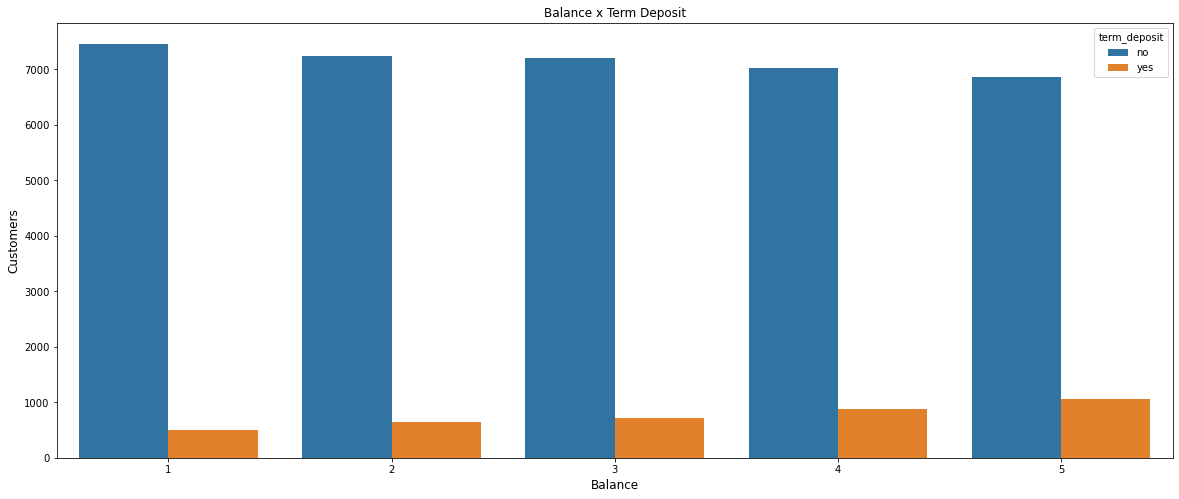

<Figure size 1440x576 with 0 Axes>

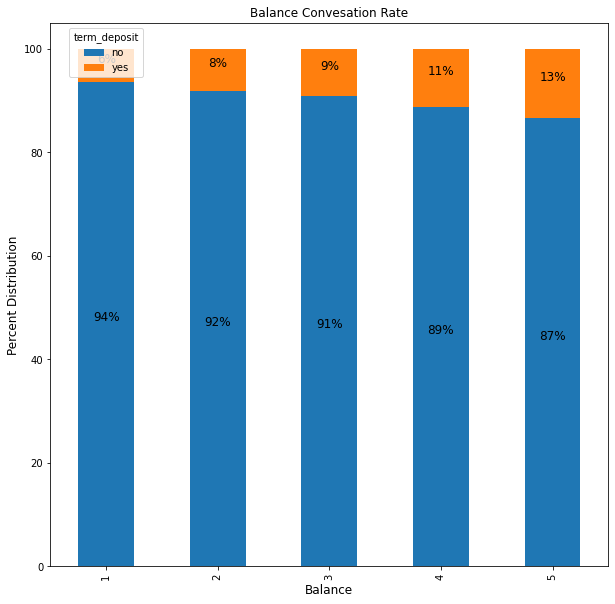

In [38]:
### Distribusi value pada feature Balance
plt.figure(figsize=(20,8))
sns.countplot(x= df['balance_cat'], data=df)
plt.xlabel('Balance',fontsize = 12)
plt.ylabel('Customers',fontsize = 12)
plt.title("Balance Distribution")

### Balance x Term Deposit (Count)
plt.figure(figsize=(20,8))
sns.countplot(x= df['balance_cat'], data=df, hue='term_deposit')
plt.xlabel('Balance',fontsize = 12)
plt.ylabel('Customers',fontsize = 12)
plt.title("Balance x Term Deposit")

### Balance Conversation Rate (%)
plt.figure(figsize=(20,8))

pal = ["royalblue", "dodgerblue"]
ax= pd.crosstab(df['balance_cat'], df['term_deposit']).apply(lambda r: r/r.sum()*100, axis=1)
ax_1 = ax.plot.bar(figsize=(10,10),stacked=True, rot=0)

plt.legend(loc='upper center', bbox_to_anchor=(0.1, 1.0), title="term_deposit")

plt.xlabel('Balance',fontsize = 12)
plt.ylabel('Percent Distribution',fontsize = 12)
plt.title("Balance Convesation Rate")
locs, labels = plt.xticks() #rotate label x axis
plt.setp(labels, rotation=90)

for rec in ax_1.patches:
    height = rec.get_height()
    ax_1.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom',
             fontsize = 12)
plt.show()

### Conclusion

In [39]:
balance_cat = pd.crosstab(df['balance_cat'], df.term_deposit)
balance_cat ['total_data'] = (balance_cat['no'] + balance_cat['yes'])
balance_cat ['convesation_rate'] = balance_cat['yes']/(balance_cat['no'] + balance_cat['yes'])
balance_cat ['%convesation'] = balance_cat['yes']/sum(balance_cat['yes'])
balance_cat.sort_values(['%convesation'], ascending = False)

term_deposit,no,yes,total_data,convesation_rate,%convesation
balance_cat,,,,,
5,6860,1062,7922,0.134057,0.278302
4,7035,886,7921,0.111855,0.232180
3,7207,721,7928,0.090943,0.188941
2,7234,641,7875,0.081397,0.167977
1,7466,506,7972,0.063472,0.132600


## Day

### Distribusi value pada feature Day

In [40]:
df['day_cat'].value_counts()

3    12497
2     9289
4     8986
1     8846
Name: day_cat, dtype: int64

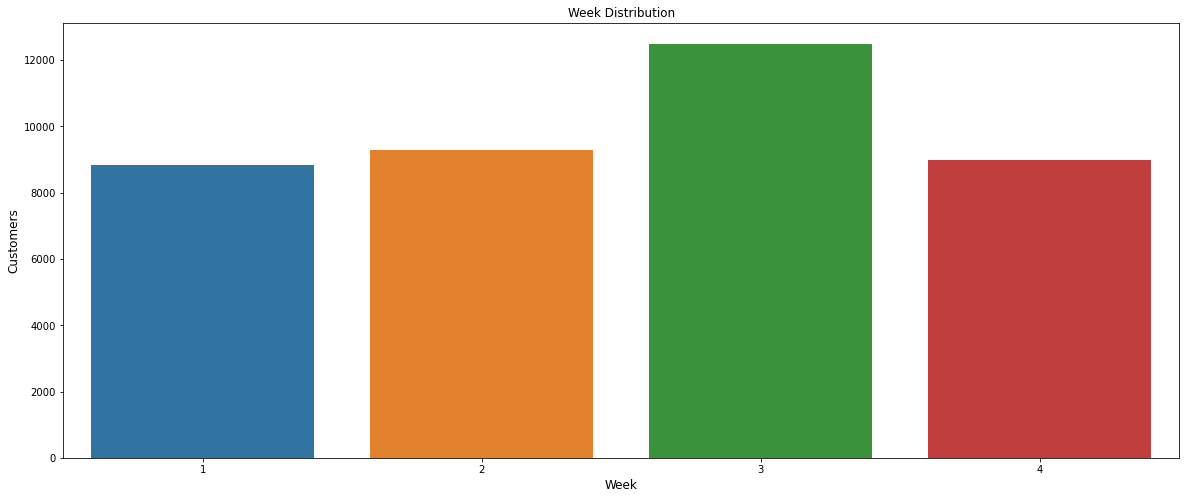

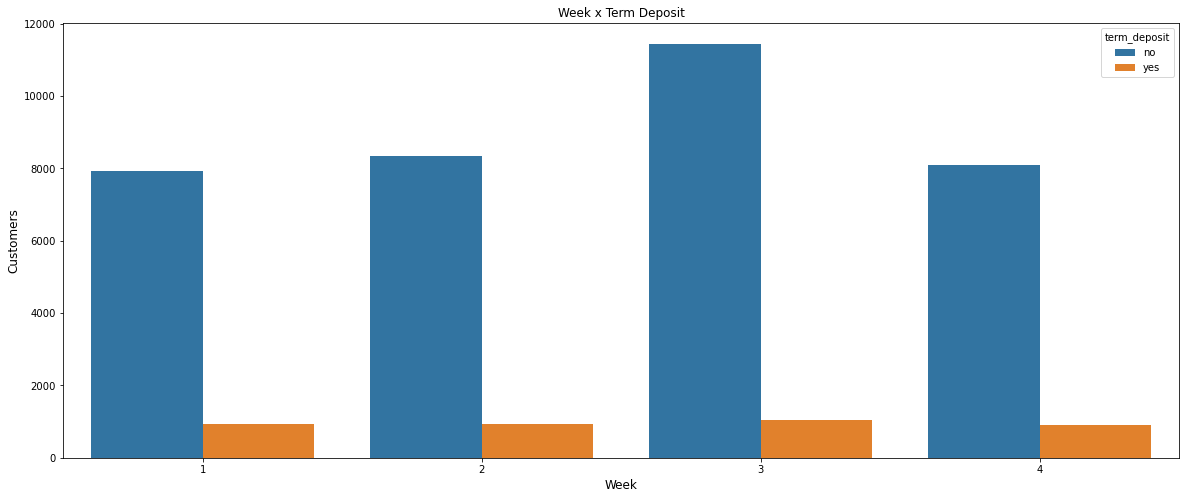

<Figure size 1440x576 with 0 Axes>

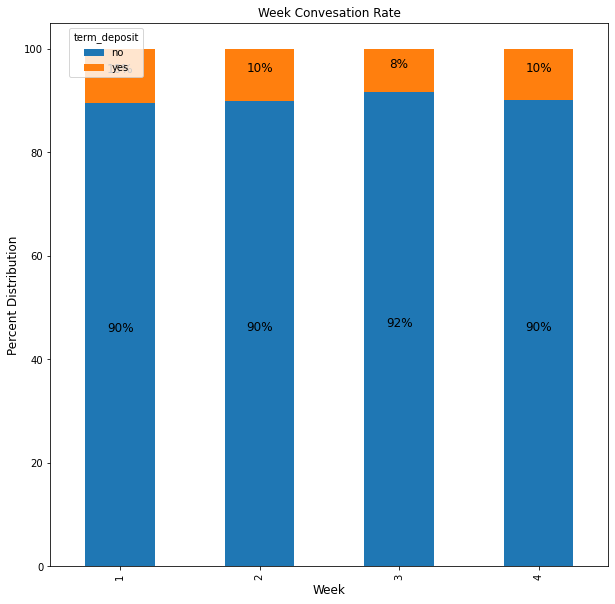

In [41]:
### Distribusi value pada feature Day
plt.figure(figsize=(20,8))
sns.countplot(x= df['day_cat'], data=df)
plt.xlabel('Week',fontsize = 12)
plt.ylabel('Customers',fontsize = 12)
plt.title("Week Distribution")

### Day x Term Deposit (Count)
plt.figure(figsize=(20,8))
sns.countplot(x= df['day_cat'], data=df, hue='term_deposit')
plt.xlabel('Week',fontsize = 12)
plt.ylabel('Customers',fontsize = 12)
plt.title("Week x Term Deposit")

### Day Conversation Rate (%)
plt.figure(figsize=(20,8))

pal = ["royalblue", "dodgerblue"]
ax= pd.crosstab(df['day_cat'], df['term_deposit']).apply(lambda r: r/r.sum()*100, axis=1)
ax_1 = ax.plot.bar(figsize=(10,10),stacked=True, rot=0)

plt.legend(loc='upper center', bbox_to_anchor=(0.1, 1.0), title="term_deposit")

plt.xlabel('Week',fontsize = 12)
plt.ylabel('Percent Distribution',fontsize = 12)
plt.title("Week Convesation Rate")
locs, labels = plt.xticks() #rotate label x axis
plt.setp(labels, rotation=90)

for rec in ax_1.patches:
    height = rec.get_height()
    ax_1.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom',
             fontsize = 12)
plt.show()

### Conclusion

In [42]:
day_cat = pd.crosstab(df['day_cat'], df.term_deposit)
day_cat ['total_data'] = (day_cat['no'] + day_cat['yes'])
day_cat ['convesation_rate'] = day_cat['yes']/(day_cat['no'] + day_cat['yes'])
day_cat ['%convesation'] = day_cat['yes']/sum(day_cat['yes'])
day_cat.sort_values(['%convesation'], ascending = False)

term_deposit,no,yes,total_data,convesation_rate,%convesation
day_cat,,,,,
3,11449,1048,12497,0.083860,0.274633
2,8342,947,9289,0.101949,0.248166
1,7921,925,8846,0.104567,0.242400
4,8090,896,8986,0.099711,0.234801


## Campaign

In [43]:
df['campaign_rev'].value_counts()

sekali           33243
jarang            5677
sering             562
sangat_sering      136
Name: campaign_rev, dtype: int64

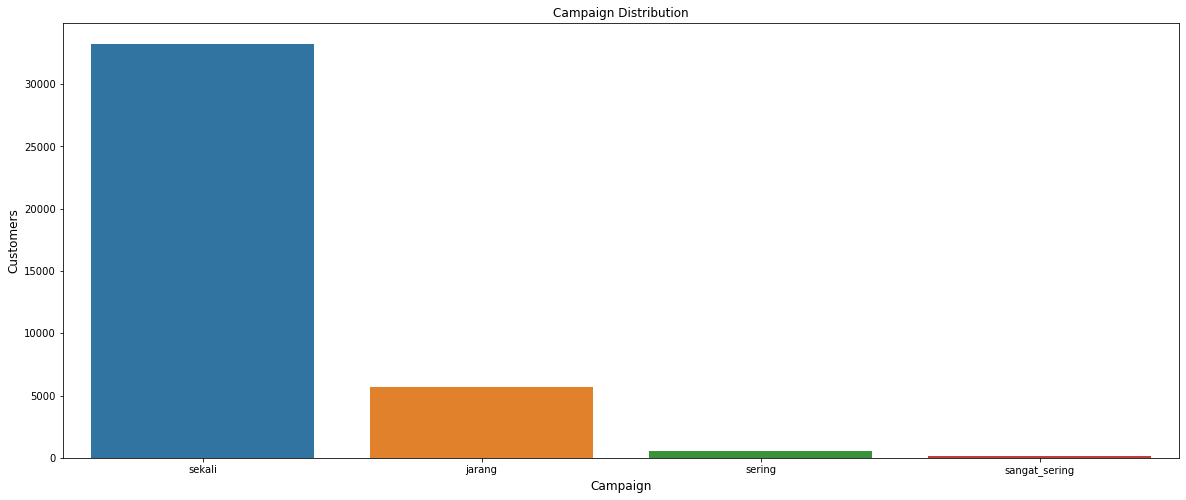

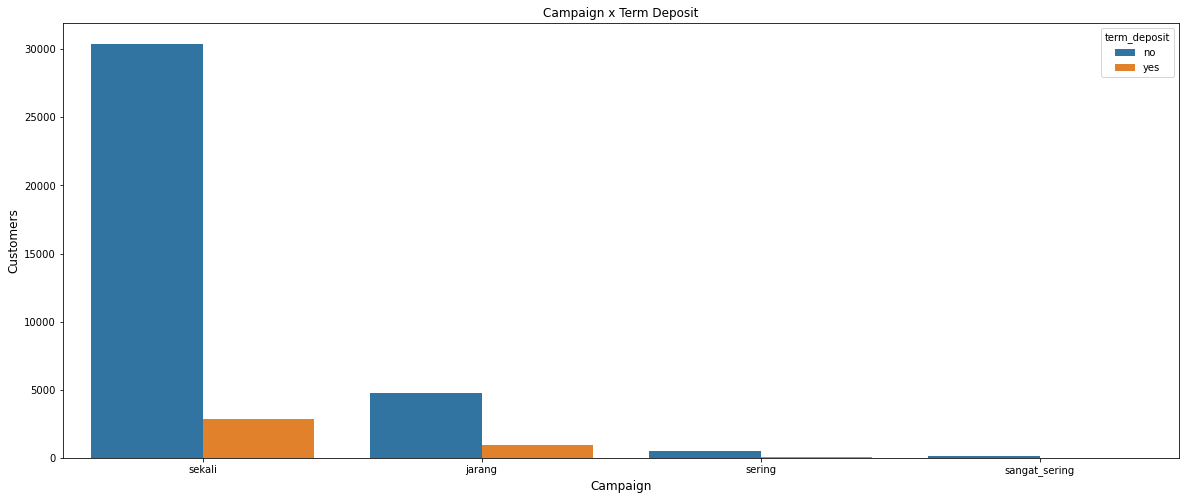

<Figure size 1440x576 with 0 Axes>

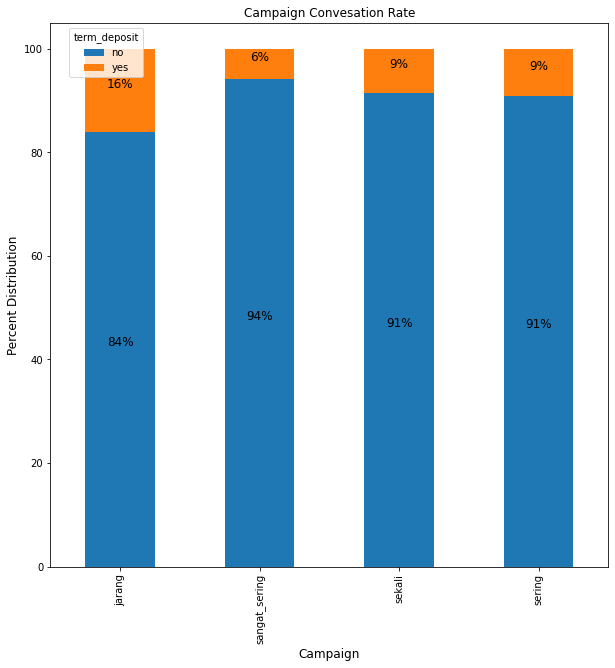

In [44]:
### Distribusi value pada feature Campaign
plt.figure(figsize=(20,8))
sns.countplot(x= df['campaign_rev'], data=df)
plt.xlabel('Campaign',fontsize = 12)
plt.ylabel('Customers',fontsize = 12)
plt.title("Campaign Distribution")

### Campaign x Term Deposit (Count)
plt.figure(figsize=(20,8))
sns.countplot(x= df['campaign_rev'], data=df, hue='term_deposit')
plt.xlabel('Campaign',fontsize = 12)
plt.ylabel('Customers',fontsize = 12)
plt.title("Campaign x Term Deposit")

### Campaign Conversation Rate (%)
plt.figure(figsize=(20,8))

pal = ["royalblue", "dodgerblue"]
ax= pd.crosstab(df['campaign_rev'], df['term_deposit']).apply(lambda r: r/r.sum()*100, axis=1)
ax_1 = ax.plot.bar(figsize=(10,10),stacked=True, rot=0)

plt.legend(loc='upper center', bbox_to_anchor=(0.1, 1.0), title="term_deposit")

plt.xlabel('Campaign',fontsize = 12)
plt.ylabel('Percent Distribution',fontsize = 12)
plt.title("Campaign Convesation Rate")
locs, labels = plt.xticks() #rotate label x axis
plt.setp(labels, rotation=90)

for rec in ax_1.patches:
    height = rec.get_height()
    ax_1.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom',
             fontsize = 12)
plt.show()

### Conclusion

In [45]:
campaign_rev = pd.crosstab(df['campaign_rev'], df.term_deposit)
campaign_rev ['total_data'] = (campaign_rev['no'] + campaign_rev['yes'])
campaign_rev ['convesation_rate'] = campaign_rev['yes']/(campaign_rev['no'] + campaign_rev['yes'])
campaign_rev ['%conversation'] = campaign_rev['yes']/sum(campaign_rev['yes'])
campaign_rev.sort_values(['%conversation'], ascending = False)

term_deposit,no,yes,total_data,convesation_rate,%conversation
campaign_rev,,,,,
sekali,30396,2847,33243,0.085642,0.746069
jarang,4767,910,5677,0.160296,0.238470
sering,511,51,562,0.090747,0.013365
sangat_sering,128,8,136,0.058824,0.002096


## Pdays

In [46]:
df['pdays_rev'].value_counts()

0     33243
1      3191
11      556
3       484
5       374
6       360
12      326
8       303
10      236
9       231
4       189
7       104
2        21
Name: pdays_rev, dtype: int64

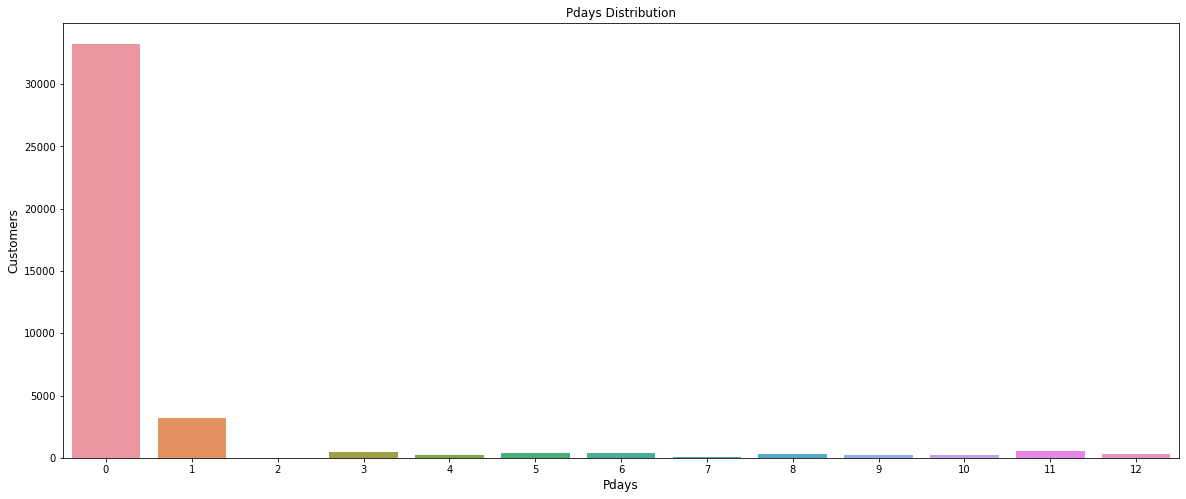

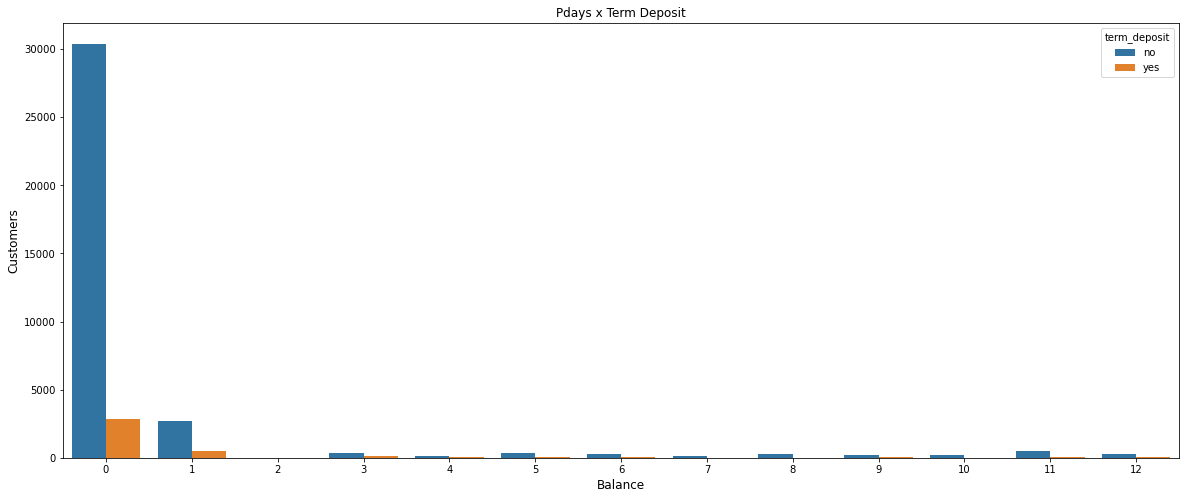

<Figure size 1440x576 with 0 Axes>

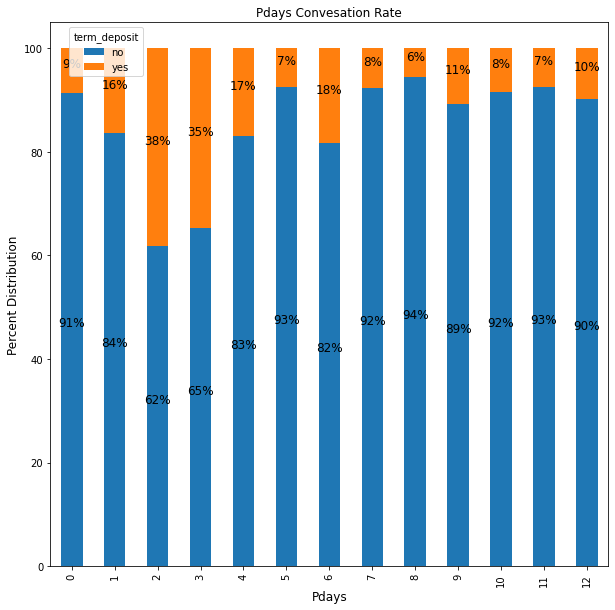

In [47]:
### Distribusi value pada feature pdays
plt.figure(figsize=(20,8))
sns.countplot(x= df['pdays_rev'], data=df)
plt.xlabel('Pdays',fontsize = 12)
plt.ylabel('Customers',fontsize = 12)
plt.title("Pdays Distribution")

### Pdays x Term Deposit (Count)
plt.figure(figsize=(20,8))
sns.countplot(x= df['pdays_rev'], data=df, hue='term_deposit')
plt.xlabel('Balance',fontsize = 12)
plt.ylabel('Customers',fontsize = 12)
plt.title("Pdays x Term Deposit")

### Pdays Conversation Rate (%)
plt.figure(figsize=(20,8))

pal = ["royalblue", "dodgerblue"]
ax= pd.crosstab(df['pdays_rev'], df['term_deposit']).apply(lambda r: r/r.sum()*100, axis=1)
ax_1 = ax.plot.bar(figsize=(10,10),stacked=True, rot=0)

plt.legend(loc='upper center', bbox_to_anchor=(0.1, 1.0), title="term_deposit")

plt.xlabel('Pdays',fontsize = 12)
plt.ylabel('Percent Distribution',fontsize = 12)
plt.title("Pdays Convesation Rate")
locs, labels = plt.xticks() #rotate label x axis
plt.setp(labels, rotation=90)

for rec in ax_1.patches:
    height = rec.get_height()
    ax_1.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom',
             fontsize = 12)
plt.show()

In [48]:
pdays_rev = pd.crosstab(df['pdays_rev'], df.term_deposit)
pdays_rev ['total_data'] = (pdays_rev['no'] + pdays_rev['yes'])
pdays_rev ['convesation_rate'] = pdays_rev['yes']/(pdays_rev['no'] + pdays_rev['yes'])
pdays_rev ['%conversation'] = pdays_rev['yes']/sum(pdays_rev['yes'])
pdays_rev.sort_values(['%conversation'], ascending = False)

term_deposit,no,yes,total_data,convesation_rate,%conversation
pdays_rev,,,,,
0,30396,2847,33243,0.085642,0.746069
1,2667,524,3191,0.164212,0.137317
3,316,168,484,0.347107,0.044025
6,294,66,360,0.183333,0.017296
11,515,41,556,0.073741,0.010744
4,157,32,189,0.169312,0.008386
12,294,32,326,0.098160,0.008386
5,346,28,374,0.074866,0.007338
9,206,25,231,0.108225,0.006551


## Job

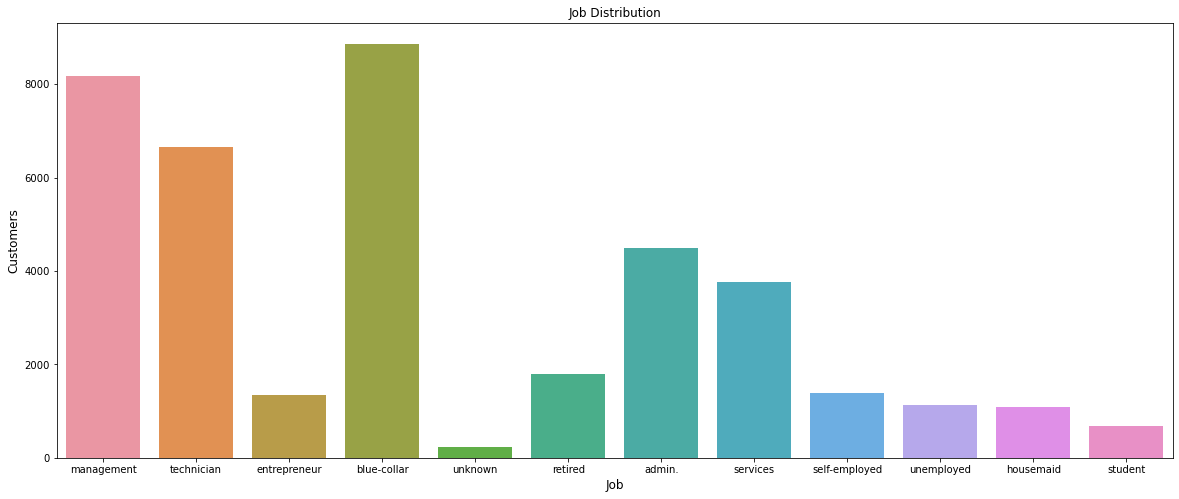

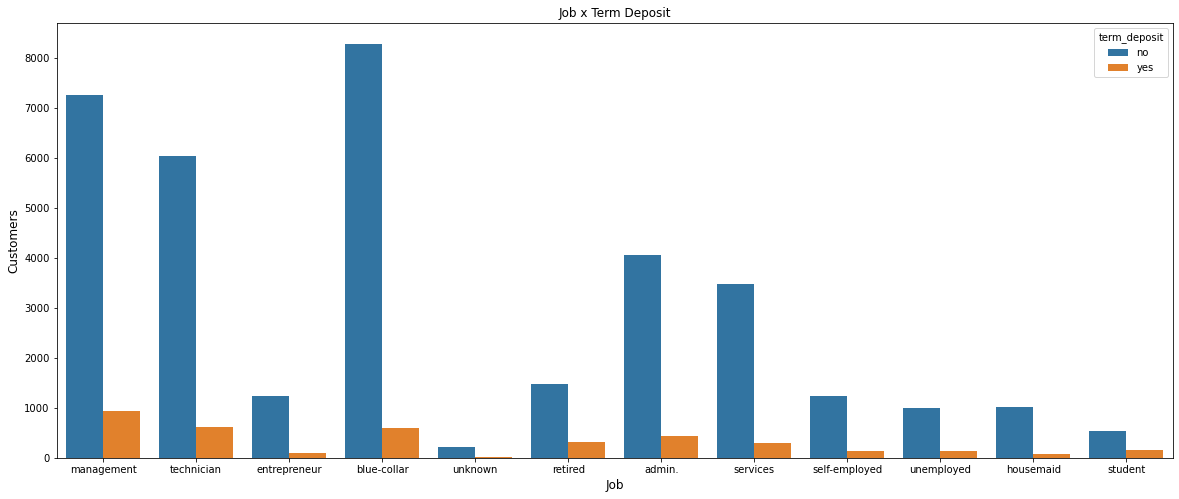

<Figure size 1440x576 with 0 Axes>

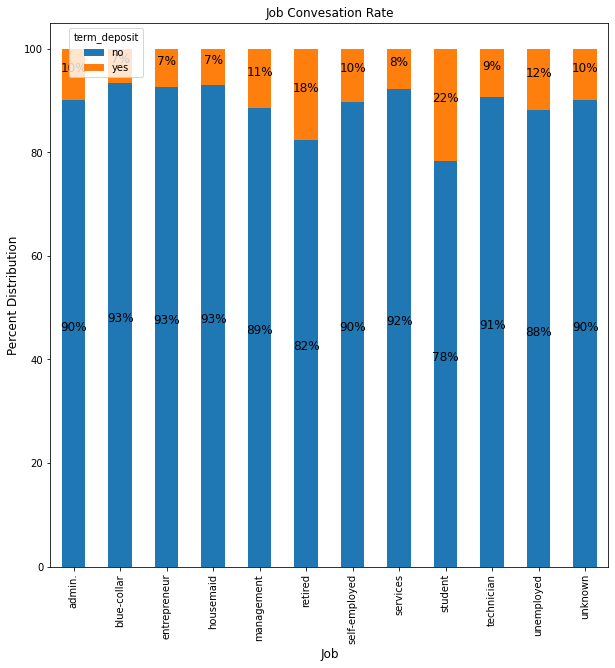

In [49]:
### Distribusi value pada feature Job
plt.figure(figsize=(20,8))
sns.countplot(x= df['job'], data=df)
plt.xlabel('Job',fontsize = 12)
plt.ylabel('Customers',fontsize = 12)
plt.title("Job Distribution")

### Job x Term Deposit (Count)
plt.figure(figsize=(20,8))
sns.countplot(x= df['job'], data=df, hue='term_deposit')
plt.xlabel('Job',fontsize = 12)
plt.ylabel('Customers',fontsize = 12)
plt.title("Job x Term Deposit")

### Job Conversation Rate (%)
plt.figure(figsize=(20,8))

pal = ["royalblue", "dodgerblue"]
ax= pd.crosstab(df['job'], df['term_deposit']).apply(lambda r: r/r.sum()*100, axis=1)
ax_1 = ax.plot.bar(figsize=(10,10),stacked=True, rot=0)

plt.legend(loc='upper center', bbox_to_anchor=(0.1, 1.0), title="term_deposit")

plt.xlabel('Job',fontsize = 12)
plt.ylabel('Percent Distribution',fontsize = 12)
plt.title("Job Convesation Rate")
locs, labels = plt.xticks() #rotate label x axis
plt.setp(labels, rotation=90)

for rec in ax_1.patches:
    height = rec.get_height()
    ax_1.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom',
             fontsize = 12)
plt.show()

### Conclucion

In [50]:
job = pd.crosstab(df['job'], df.term_deposit)
job ['total_data'] = (job['no'] + job['yes'])
job ['convesation_rate'] = job['yes']/(job['no'] + job['yes'])
job ['%conversation'] = job['yes']/sum(job['yes'])
job.sort_values(['%conversation'], ascending = False)

term_deposit,no,yes,total_data,convesation_rate,%conversation
job,,,,,
management,7244,931,8175,0.113884,0.243973
technician,6032,625,6657,0.093886,0.163784
blue-collar,8281,586,8867,0.066088,0.153564
admin.,4053,445,4498,0.098933,0.116614
retired,1480,315,1795,0.175487,0.082547
services,3465,293,3758,0.077967,0.076782
student,536,149,685,0.217518,0.039046
self-employed,1244,141,1385,0.101805,0.036950
unemployed,1000,134,1134,0.118166,0.035115


## Marital

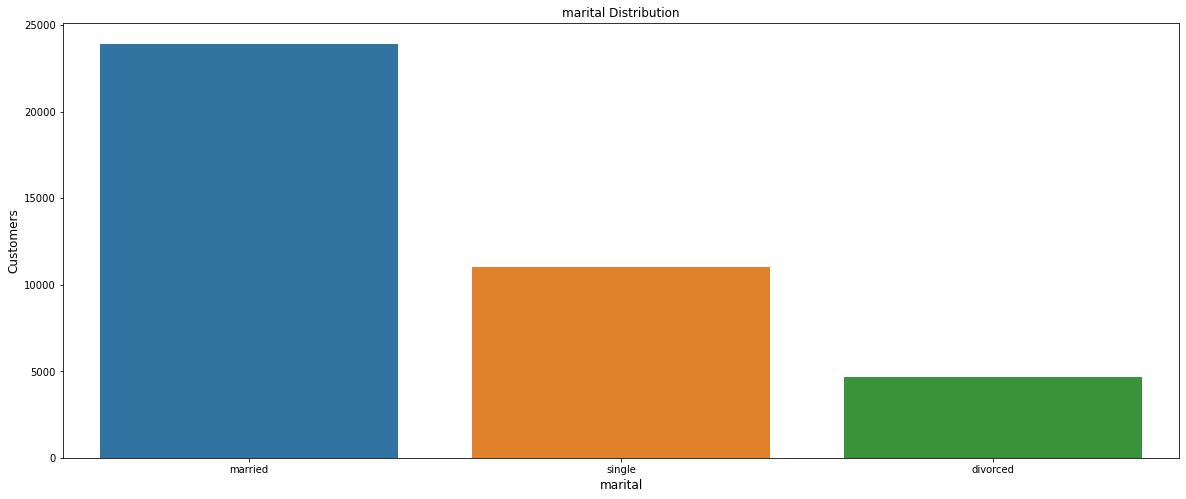

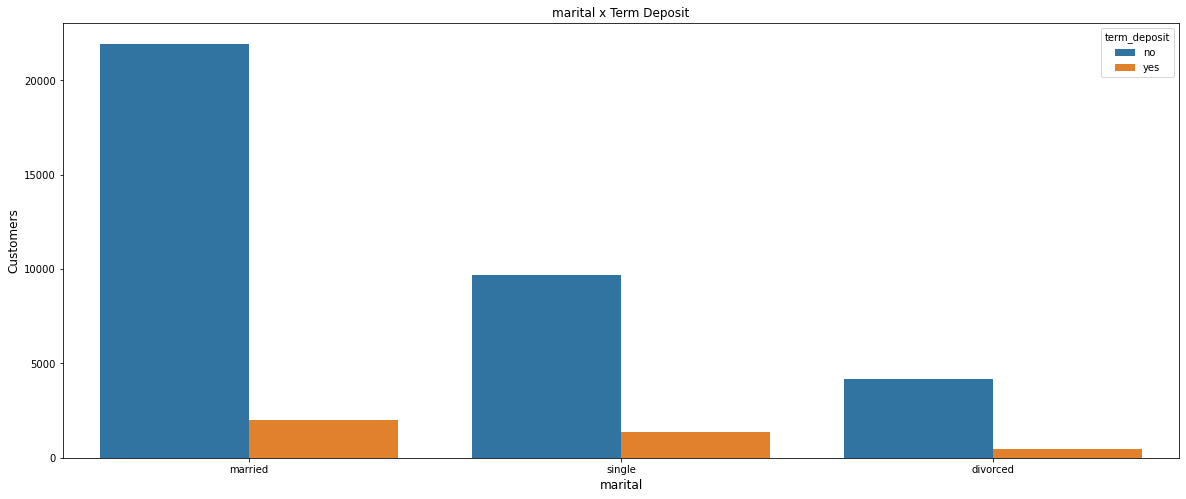

<Figure size 1440x576 with 0 Axes>

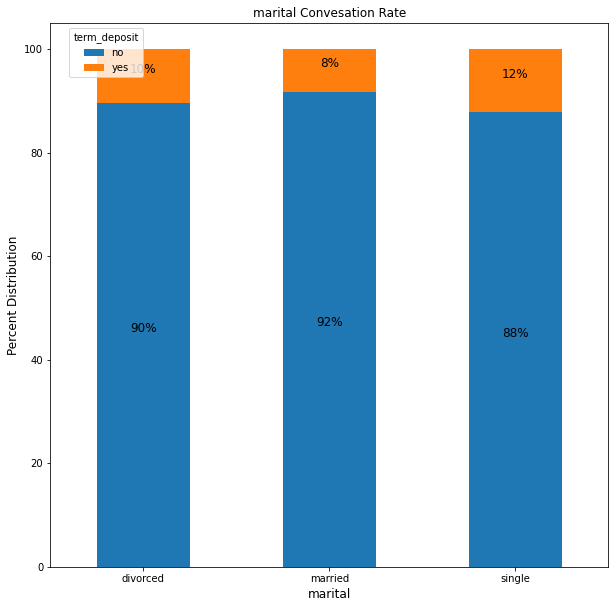

In [51]:
### Distribusi value pada feature marital
plt.figure(figsize=(20,8))
sns.countplot(x= df['marital'], data=df)
plt.xlabel('marital',fontsize = 12)
plt.ylabel('Customers',fontsize = 12)
plt.title("marital Distribution")

### marital x Term Deposit (Count)
plt.figure(figsize=(20,8))
sns.countplot(x= df['marital'], data=df, hue='term_deposit')
plt.xlabel('marital',fontsize = 12)
plt.ylabel('Customers',fontsize = 12)
plt.title("marital x Term Deposit")

### marital Conversation Rate (%)
plt.figure(figsize=(20,8))

pal = ["royalblue", "dodgerblue"]
ax= pd.crosstab(df['marital'], df['term_deposit']).apply(lambda r: r/r.sum()*100, axis=1)
ax_1 = ax.plot.bar(figsize=(10,10),stacked=True, rot=0)

plt.legend(loc='upper center', bbox_to_anchor=(0.1, 1.0), title="term_deposit")

plt.xlabel('marital',fontsize = 12)
plt.ylabel('Percent Distribution',fontsize = 12)
plt.title("marital Convesation Rate")


for rec in ax_1.patches:
    height = rec.get_height()
    ax_1.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom',
             fontsize = 12)
plt.show()

### Conclucion

In [52]:
marital = pd.crosstab(df['marital'], df.term_deposit)
marital ['total_data'] = (marital['no'] + marital['yes'])
marital ['convesation_rate'] = marital['yes']/(marital['no'] + marital['yes'])
marital ['%conversation'] = marital['yes']/sum(marital['yes'])
marital.sort_values(['%conversation'], ascending = False)

term_deposit,no,yes,total_data,convesation_rate,%conversation
marital,,,,,
married,21951,1979,23930,0.082700,0.518606
single,9674,1348,11022,0.122301,0.353249
divorced,4177,489,4666,0.104801,0.128145


## Housing

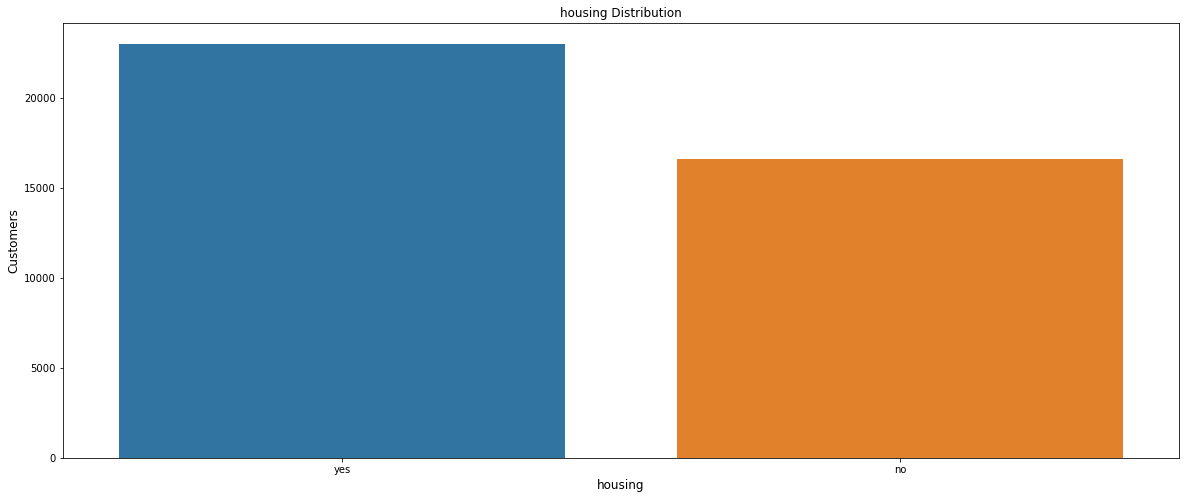

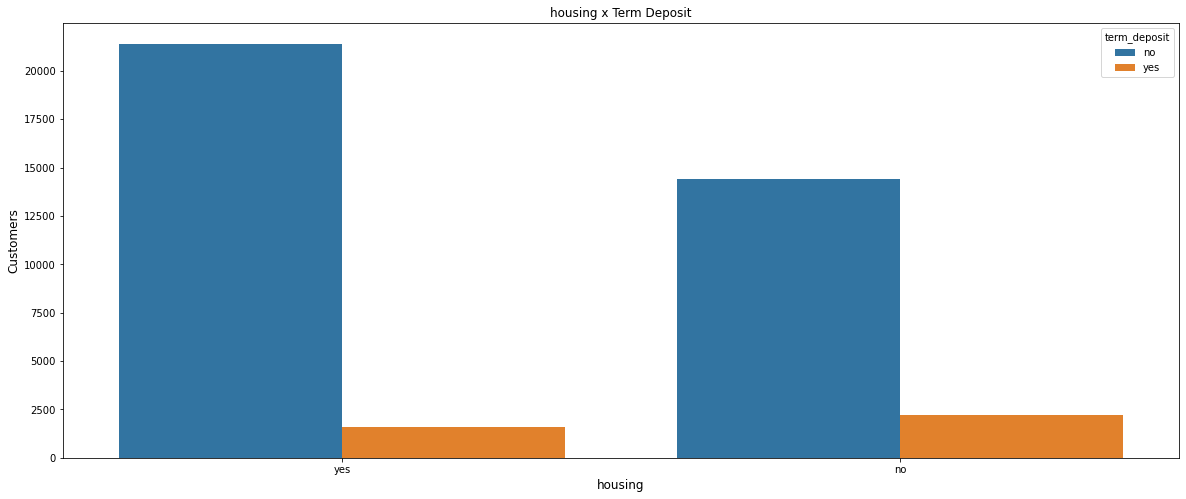

<Figure size 1440x576 with 0 Axes>

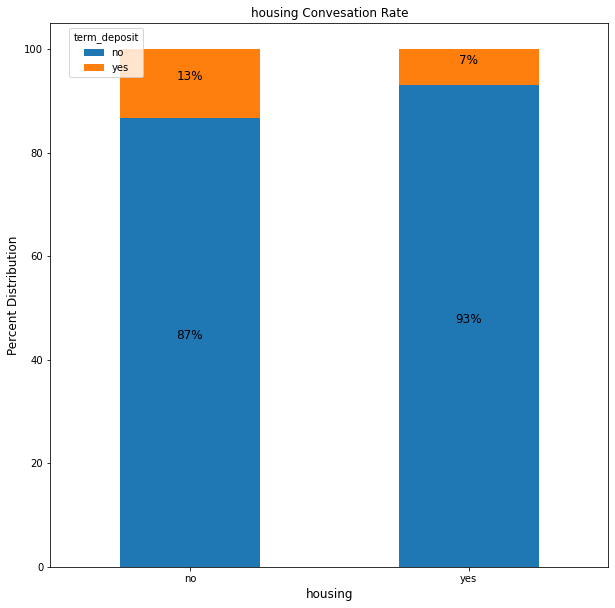

In [53]:
### Distribusi value pada feature housing
plt.figure(figsize=(20,8))
sns.countplot(x= df['housing'], data=df)
plt.xlabel('housing',fontsize = 12)
plt.ylabel('Customers',fontsize = 12)
plt.title("housing Distribution")

### housing x Term Deposit (Count)
plt.figure(figsize=(20,8))
sns.countplot(x= df['housing'], data=df, hue='term_deposit')
plt.xlabel('housing',fontsize = 12)
plt.ylabel('Customers',fontsize = 12)
plt.title("housing x Term Deposit")

### housing Conversation Rate (%)
plt.figure(figsize=(20,8))

pal = ["royalblue", "dodgerblue"]
ax= pd.crosstab(df['housing'], df['term_deposit']).apply(lambda r: r/r.sum()*100, axis=1)
ax_1 = ax.plot.bar(figsize=(10,10),stacked=True, rot=0)

plt.legend(loc='upper center', bbox_to_anchor=(0.1, 1.0), title="term_deposit")

plt.xlabel('housing',fontsize = 12)
plt.ylabel('Percent Distribution',fontsize = 12)
plt.title("housing Convesation Rate")


for rec in ax_1.patches:
    height = rec.get_height()
    ax_1.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom',
             fontsize = 12)
plt.show()

### Conclucion

In [54]:
housing = pd.crosstab(df['housing'], df.term_deposit)
housing ['total_data'] = (housing['no'] + housing['yes'])
housing ['convesation_rate'] = housing['yes']/(housing['no'] + housing['yes'])
housing ['%conversation'] = housing['yes']/sum(housing['yes'])
housing.sort_values(['%conversation'], ascending = False)

term_deposit,no,yes,total_data,convesation_rate,%conversation
housing,,,,,
no,14395,2207,16602,0.132936,0.578354
yes,21407,1609,23016,0.069908,0.421646


## Loan

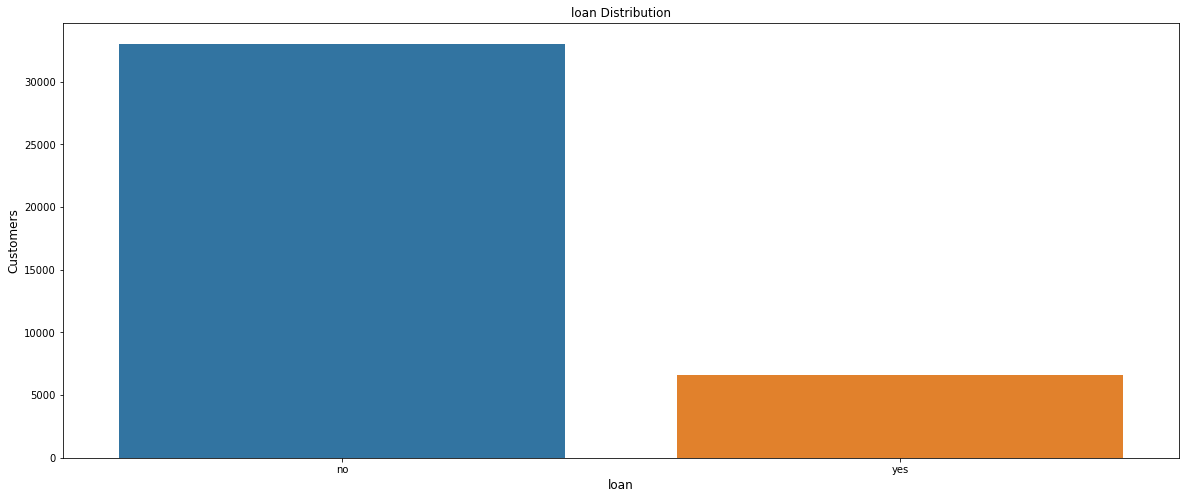

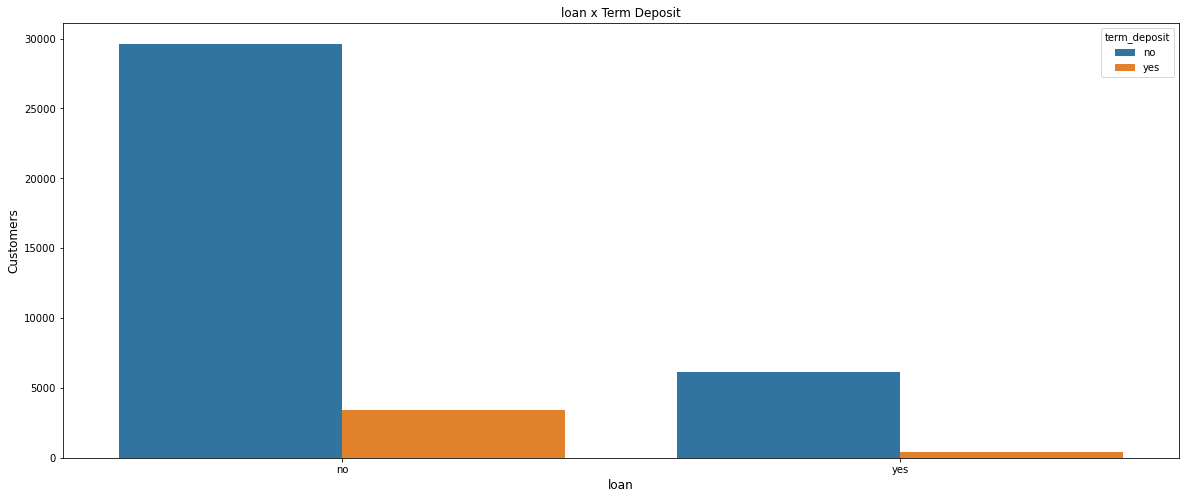

<Figure size 1440x576 with 0 Axes>

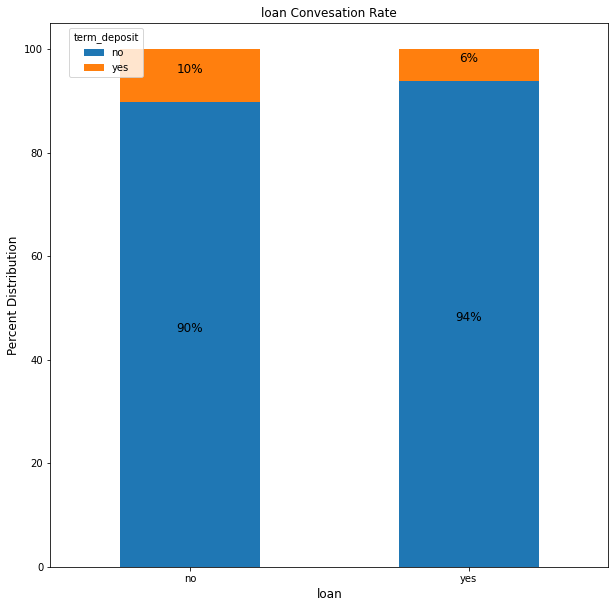

In [55]:
### Distribusi value pada feature housing
plt.figure(figsize=(20,8))
sns.countplot(x= df['loan'], data=df)
plt.xlabel('loan',fontsize = 12)
plt.ylabel('Customers',fontsize = 12)
plt.title("loan Distribution")

### housing x Term Deposit (Count)
plt.figure(figsize=(20,8))
sns.countplot(x= df['loan'], data=df, hue='term_deposit')
plt.xlabel('loan',fontsize = 12)
plt.ylabel('Customers',fontsize = 12)
plt.title("loan x Term Deposit")

### housing Conversation Rate (%)
plt.figure(figsize=(20,8))

pal = ["royalblue", "dodgerblue"]
ax= pd.crosstab(df['loan'], df['term_deposit']).apply(lambda r: r/r.sum()*100, axis=1)
ax_1 = ax.plot.bar(figsize=(10,10),stacked=True, rot=0)

plt.legend(loc='upper center', bbox_to_anchor=(0.1, 1.0), title="term_deposit")

plt.xlabel('loan',fontsize = 12)
plt.ylabel('Percent Distribution',fontsize = 12)
plt.title("loan Convesation Rate")


for rec in ax_1.patches:
    height = rec.get_height()
    ax_1.text(rec.get_x() + rec.get_width() / 2, 
              rec.get_y() + height / 2,
              "{:.0f}%".format(height),
              ha='center', 
              va='bottom',
             fontsize = 12)
plt.show()

### Conclusion

In [56]:
loan = pd.crosstab(df['loan'], df.term_deposit)
loan ['total_data'] = (loan['no'] + loan['yes'])
loan ['convesation_rate'] = loan['yes']/(loan['no'] + loan['yes'])
loan ['%conversation'] = loan['yes']/sum(loan['yes'])
loan.sort_values(['%conversation'], ascending = False)

term_deposit,no,yes,total_data,convesation_rate,%conversation
loan,,,,,
no,29639,3407,33046,0.103099,0.89282
yes,6163,409,6572,0.062234,0.10718


## Term Deposit (Target)

Text(0.5, 1.0, 'term_deposit Distribution')

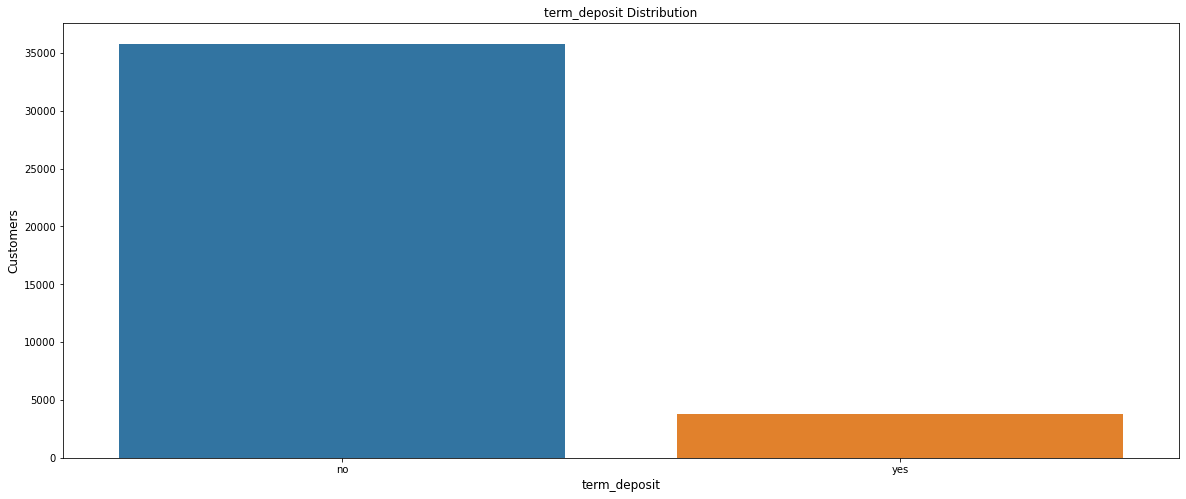

In [57]:
plt.figure(figsize=(20,8))
sns.countplot(x= df['term_deposit'], data=df)
plt.xlabel('term_deposit',fontsize = 12)
plt.ylabel('Customers',fontsize = 12)
plt.title("term_deposit Distribution")

Term Deposit memiliki distribusi data yang imbalance, pada model akan menggunakan class weigh untuk menangani class imbalance

## Job X Month X Term Deposit

Analisa lanjutan untuk populasi terbesar pada job yaitu : 
1. management
2. blue-collar
3. technician
4. admin

### Management

In [58]:
yes = df[(df['term_deposit']=='yes')]
no = df[(df['term_deposit']=='no')]
bulano= pd.crosstab(no['month'], no['job']).apply(lambda r: r, axis=1)
data_pop = df[(df['job']=='management')]
data_pop = pd.crosstab(data_pop['month'], data_pop['job']).apply(lambda r: r, axis=1)
yes_data = yes[(yes['job']=='management')]
no_data = no[(no['job']=='management')]
bulanyes_data = pd.crosstab(yes_data['month'], yes_data['job']).apply(lambda r: r, axis=1)
ration = (bulanyes_data/data_pop)*100
ration['yes'] = yes_data.groupby(['month'])['term_deposit'].count()
ration['no'] = no_data.groupby(['month'])['term_deposit'].count()
ration['total'] = ration['no'] + ration['yes']
ration['All_campaign'] = df.groupby(['month'])['term_deposit'].count()
ration['percent_campaign'] = ration['total']/ration['All_campaign']
ration.sort_values(['total'], ascending = False)

job,management,yes,no,total,All_campaign,percent_campaign
month,,,,,,
may,6.802383,137,1877,2014,12882,0.156342
aug,10.104103,165,1468,1633,5122,0.318821
jul,6.613757,75,1059,1134,5826,0.194645
nov,9.107981,97,968,1065,3824,0.278504
jun,13.164557,104,686,790,4634,0.170479
apr,23.076923,114,380,494,2686,0.183917
feb,13.968958,63,388,451,2173,0.207547
jan,2.766798,7,246,253,1224,0.206699
oct,47.200000,59,66,125,518,0.241313


Best Month for management
- April
- juni

### Admin

In [59]:
no = df[(df['term_deposit']=='no')]
bulano= pd.crosstab(no['month'], no['job']).apply(lambda r: r, axis=1)
data_pop = df[(df['job']=='admin.')]
data_pop = pd.crosstab(data_pop['month'], data_pop['job']).apply(lambda r: r, axis=1)
yes_data = yes[(yes['job']=='admin.')]
no_data = no[(no['job']=='admin.')]
bulanyes_data = pd.crosstab(yes_data['month'], yes_data['job']).apply(lambda r: r, axis=1)
ration = (bulanyes_data/data_pop)*100
ration['yes'] = yes_data.groupby(['month'])['term_deposit'].count()
ration['no'] = no_data.groupby(['month'])['term_deposit'].count()
ration['total'] = ration['no'] + ration['yes']
ration['All_campaign'] = df.groupby(['month'])['term_deposit'].count()
ration['percent_campaign'] = ration['total']/ration['All_campaign']
ration.sort_values(['yes'], ascending = False)

job,admin.,yes,no,total,All_campaign,percent_campaign
month,,,,,,
may,7.030303,116,1534,1650,12882,0.128086
apr,14.784946,55,317,372,2686,0.138496
jun,9.902913,51,464,515,4634,0.111135
jul,5.823864,41,663,704,5826,0.120838
aug,13.937282,40,247,287,5122,0.056033
nov,8.955224,36,366,402,3824,0.105126
feb,12.109375,31,225,256,2173,0.117809
oct,33.823529,23,45,68,518,0.131274
mar,41.463415,17,24,41,243,0.168724


Best Month for Admin
- April
- Aug

### technician

In [60]:
no = df[(df['term_deposit']=='no')]
bulano= pd.crosstab(no['month'], no['job']).apply(lambda r: r, axis=1)
data_pop = df[(df['job']=='technician')]
data_pop = pd.crosstab(data_pop['month'], data_pop['job']).apply(lambda r: r, axis=1)
yes_data = yes[(yes['job']=='technician')]
no_data = no[(no['job']=='technician')]
bulanyes_data = pd.crosstab(yes_data['month'], yes_data['job']).apply(lambda r: r, axis=1)
ration = (bulanyes_data/data_pop)*100
ration['yes'] = yes_data.groupby(['month'])['term_deposit'].count()
ration['no'] = no_data.groupby(['month'])['term_deposit'].count()
ration['total'] = ration['no'] + ration['yes']
ration['All_campaign'] = df.groupby(['month'])['term_deposit'].count()
ration['percent_campaign'] = ration['total']/ration['All_campaign']
ration.sort_values(['yes'], ascending = False)

job,technician,yes,no,total,All_campaign,percent_campaign
month,,,,,,
aug,7.594937,114,1387,1501,5122,0.293050
may,5.848564,112,1803,1915,12882,0.148657
apr,19.587629,76,312,388,2686,0.144453
jun,10.634648,62,521,583,4634,0.125809
jul,6.652126,61,856,917,5826,0.157398
nov,9.430894,58,557,615,3824,0.160826
feb,13.005780,45,301,346,2173,0.159227
oct,58.571429,41,29,70,518,0.135135
mar,47.222222,17,19,36,243,0.148148


Best Month for technician
- April
- oct

### Blue-collar

In [61]:
no = df[(df['term_deposit']=='no')]
bulano= pd.crosstab(no['month'], no['job']).apply(lambda r: r, axis=1)
data_pop = df[(df['job']=='blue-collar')]
data_pop = pd.crosstab(data_pop['month'], data_pop['job']).apply(lambda r: r, axis=1)
yes_data = yes[(yes['job']=='blue-collar')]
no_data = no[(no['job']=='blue-collar')]
bulanyes_data = pd.crosstab(yes_data['month'], yes_data['job']).apply(lambda r: r, axis=1)
ration = (bulanyes_data/data_pop)*100
ration['yes'] = yes_data.groupby(['month'])['term_deposit'].count()
ration['no'] = no_data.groupby(['month'])['term_deposit'].count()
ration['total'] = ration['no'] + ration['yes']
ration['All_campaign'] = df.groupby(['month'])['term_deposit'].count()
ration['percent_campaign'] = ration['total']/ration['All_campaign']
ration.sort_values(['yes'], ascending = False)

job,blue-collar,yes,no,total,All_campaign,percent_campaign
month,,,,,,
may,5.104015,211,3923,4134,12882,0.320913
jul,7.755102,95,1130,1225,5826,0.210264
jun,6.375228,70,1028,1098,4634,0.236944
apr,8.991826,66,668,734,2686,0.273269
nov,7.300509,43,546,589,3824,0.154027
aug,8.453608,41,444,485,5122,0.094690
feb,5.397727,19,333,352,2173,0.161988
oct,39.024390,16,25,41,518,0.079151
sep,83.333333,10,2,12,278,0.043165


Best Month for Blue Collar
- April
- Juli

## Campaign X Pdays X Term Deposit

Analisa lanjutan antara korelasi campaign dengan pdays dengan term deposit, untuk mengetahui jumlah campaign dan jarak antar campaign yang lebih potensial

### Kelompok campaign 1 - 3 kali (jarang)

In [62]:
yes = df[(df['term_deposit']=='yes')]
no = df[(df['term_deposit']=='no')]
bulano= pd.crosstab(no['pdays_rev'], no['campaign_rev']).apply(lambda r: r, axis=1)
data_pop = df[(df['campaign_rev']=='jarang')]
data_pop = pd.crosstab(data_pop['pdays_rev'], data_pop['campaign_rev']).apply(lambda r: r, axis=1)
yes_data = yes[(yes['campaign_rev']=='jarang')]
no_data = no[(no['campaign_rev']=='jarang')]
bulanyes_data = pd.crosstab(yes_data['pdays_rev'], yes_data['campaign_rev']).apply(lambda r: r, axis=1)
ration = (bulanyes_data/data_pop)*100
ration['yes'] = yes_data.groupby(['pdays_rev'])['campaign_rev'].count()
ration['no'] = no_data.groupby(['pdays_rev'])['campaign_rev'].count()
ration['total'] = ration['no'] + ration['yes']
ration['All_campaign'] = df.groupby(['pdays_rev'])['campaign_rev'].count()
ration['percent_campaign'] = ration['total']/ration['All_campaign']
ration.sort_values(['yes'], ascending = False)

campaign_rev,jarang,yes,no,total,All_campaign,percent_campaign
pdays_rev,,,,,,
1,16.514340,524,2649,3173,3191,0.994359
3,38.709677,156,247,403,484,0.832645
6,19.366197,55,229,284,360,0.788889
11,7.025761,30,397,427,556,0.767986
4,17.500000,28,132,160,189,0.846561
9,13.661202,25,158,183,231,0.792208
12,10.330579,25,217,242,326,0.742331
5,8.000000,22,253,275,374,0.735294
10,9.189189,17,168,185,236,0.783898


Untuk campaign 1 - 3 kali, jarak ideal antar campaign adalah 4 bulan dengan conversation rate 38,70%

### Kelompok campaign 4 - 5 kali (Sering)

In [63]:
yes = df[(df['term_deposit']=='yes')]
no = df[(df['term_deposit']=='no')]
bulano= pd.crosstab(no['pdays_rev'], no['campaign_rev']).apply(lambda r: r, axis=1)
data_pop = df[(df['campaign_rev']=='sering')]
data_pop = pd.crosstab(data_pop['pdays_rev'], data_pop['campaign_rev']).apply(lambda r: r, axis=1)
yes_data = yes[(yes['campaign_rev']=='sering')]
no_data = no[(no['campaign_rev']=='sering')]
bulanyes_data = pd.crosstab(yes_data['pdays_rev'], yes_data['campaign_rev']).apply(lambda r: r, axis=1)
ration = (bulanyes_data/data_pop)*100
ration['yes'] = yes_data.groupby(['pdays_rev'])['campaign_rev'].count()
ration['no'] = no_data.groupby(['pdays_rev'])['campaign_rev'].count()
ration['total'] = ration['no'] + ration['yes']
ration['All_campaign'] = df.groupby(['pdays_rev'])['campaign_rev'].count()
ration['percent_campaign'] = ration['total']/ration['All_campaign']
ration.sort_values(['yes'], ascending = False)

campaign_rev,sering,yes,no,total,All_campaign,percent_campaign
pdays_rev,,,,,,
6,18.032787,11.0,50,61.0,360,0.169444
11,9.259259,10.0,98,108.0,556,0.194245
3,12.307692,8.0,57,65.0,484,0.134298
12,8.955224,6.0,61,67.0,326,0.205521
5,6.849315,5.0,68,73.0,374,0.195187
4,15.384615,4.0,22,26.0,189,0.137566
8,8.163265,4.0,45,49.0,303,0.161716
10,4.878049,2.0,39,41.0,236,0.173729
7,7.692308,1.0,12,13.0,104,0.125000


Untuk campaign 4 - 5 kali, jarak ideal antar campaign adalah 7 bulan dengan conversation rate 11%

### Kelompok campaign 6 dan seterusnya (Sangat Sering)

In [64]:
yes = df[(df['term_deposit']=='yes')]
no = df[(df['term_deposit']=='no')]
bulano= pd.crosstab(no['pdays_rev'], no['campaign_rev']).apply(lambda r: r, axis=1)
data_pop = df[(df['campaign_rev']=='sangat_sering')]
data_pop = pd.crosstab(data_pop['pdays_rev'], data_pop['campaign_rev']).apply(lambda r: r, axis=1)
yes_data = yes[(yes['campaign_rev']=='sangat_sering')]
no_data = no[(no['campaign_rev']=='sangat_sering')]
bulanyes_data = pd.crosstab(yes_data['pdays_rev'], yes_data['campaign_rev']).apply(lambda r: r, axis=1)
ration = (bulanyes_data/data_pop)*100
ration['yes'] = yes_data.groupby(['pdays_rev'])['campaign_rev'].count()
ration['no'] = no_data.groupby(['pdays_rev'])['campaign_rev'].count()
ration['total'] = ration['no'] + ration['yes']
ration['All_campaign'] = df.groupby(['pdays_rev'])['campaign_rev'].count()
ration['percent_campaign'] = ration['total']/ration['All_campaign']
ration.sort_values(['yes'], ascending = False)

campaign_rev,sangat_sering,yes,no,total,All_campaign,percent_campaign
pdays_rev,,,,,,
3,25.000000,4.0,12,16.0,484,0.033058
5,3.846154,1.0,25,26.0,374,0.069519
10,10.000000,1.0,9,10.0,236,0.042373
11,4.761905,1.0,20,21.0,556,0.037770
12,5.882353,1.0,16,17.0,326,0.052147
1,NaN,NaN,3,NaN,3191,NaN
2,NaN,NaN,1,NaN,21,NaN
4,NaN,NaN,3,NaN,189,NaN
6,NaN,NaN,15,NaN,360,NaN


Untuk campaign yang ke 6 kali dan seterusnya, jarak ideal antar campaign adalah 4 bulan dengan conversation rate 25%

# Modeling

In [65]:
y = df["term_deposit"].map({"no":0, "yes":1})
X = df.drop("term_deposit", axis=1)

In [66]:
X.drop("duration", inplace=True, axis=1)

In [67]:
X.drop("default", inplace=True, axis=1)

In [68]:
X.drop("previous", inplace=True, axis=1)

In [69]:
X.dtypes

age              int64
job             object
marital         object
education       object
balance          int64
housing         object
loan            object
contact         object
day              int64
month           object
campaign         int64
pdays            int64
poutcome        object
age_cat         object
balance_cat      int64
day_cat          int64
pdyas_new        int64
campaign_cat    object
pdays_rev        int64
campaign_rev    object
dtype: object

In [70]:
num_features = ['pdays_rev','balance_cat']

cat_features = ["job",'marital', "education","housing", "loan","contact",  "poutcome",'month','campaign_rev','age_cat']

### Feature Encoding

We'll define a new ColumnTransformer object. that keeps our numerical features and apply one hot encoding on our categorical features. That will allow us to create a clean pipeline that includes both features engineering (one hot encoding here) and training the model (a nice way to avoid data leakage)

In [71]:
preprocessor = ColumnTransformer([("numerical", "passthrough", num_features), 
                                  ("categorical", OneHotEncoder(sparse=False, handle_unknown="ignore"),
                                   cat_features)])

### Creating Model

we can define our 4 models as sklearn Pipeline object, containing our preprocessing step and training of one given algorithm.

In [72]:
# Logistic Regression
lr_model = Pipeline([("preprocessor", preprocessor), 
                     ("model", LogisticRegression(class_weight={0: 0.095, 1: 0.905}, solver="liblinear", random_state=42))])

# Decision Tree
dt_model = Pipeline([("preprocessor", preprocessor), 
                     ("model", DecisionTreeClassifier(class_weight={0: 0.095, 1: 0.905}))])

# Random Forest
rf_model = Pipeline([("preprocessor", preprocessor), 
                     ("model", RandomForestClassifier(class_weight={0: 0.095, 1: 0.905}, n_estimators=100, n_jobs=-1))])

# XGBoost
xgb_model = Pipeline([("preprocessor", preprocessor), 
                      # Add a scale_pos_weight to make it balanced
                      ("model", XGBClassifier(scale_pos_weight=(1 - y.mean()), n_jobs=-1))])

#### Splitting data 

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.3, random_state=42)

#### Logistic Regression

First let's fine tune our logistic regression and evaluate its performance.

In [74]:
gs = GridSearchCV(lr_model, {"model__C": [1, 1.3, 1.5]}, n_jobs=-1, cv=5, scoring="recall")
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         'passthrough',
                                                                         ['pdays_rev',
                                                                          'balance_cat']),
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                  

Let's see our best parameters and score

In [75]:
print(gs.best_params_)
print(gs.best_score_)

{'model__C': 1}
0.6196205677482586


In [76]:
lr_model.set_params(**gs.best_params_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['pdays_rev', 'balance_cat']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['job', 'marital',
                                                   'education', 'housing',
                                                   'loan', 'contact',
                                                   'poutcome', 'month',
                                                   'campaign_rev',
                                                   'age_cat'])])),
                ('model',
                 LogisticRegression(C=1, class_weight={0: 0.095, 1: 0.905},
                                    random_state=42, 

In [77]:
lr_model.get_params("model")

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('numerical', 'passthrough',
                                    ['pdays_rev', 'balance_cat']),
                                   ('categorical',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    ['job', 'marital', 'education', 'housing',
                                     'loan', 'contact', 'poutcome', 'month',
                                     'campaign_rev', 'age_cat'])])),
  ('model',
   LogisticRegression(C=1, class_weight={0: 0.095, 1: 0.905}, random_state=42,
                      solver='liblinear'))],
 'verbose': False,
 'preprocessor': ColumnTransformer(transformers=[('numerical', 'passthrough',
                                  ['pdays_rev', 'balance_cat']),
                                 ('categorical',
                                  OneHotEncoder(handle_unknow

### Training

In [78]:
lr_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['pdays_rev', 'balance_cat']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['job', 'marital',
                                                   'education', 'housing',
                                                   'loan', 'contact',
                                                   'poutcome', 'month',
                                                   'campaign_rev',
                                                   'age_cat'])])),
                ('model',
                 LogisticRegression(C=1, class_weight={0: 0.095, 1: 0.905},
                                    random_state=42, 

### Evaluation

In [79]:
y_pred = lr_model.predict(X_test)

In [80]:
accuracy_score(y_test, y_pred)

0.7226148409893993

In [81]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

def eval_classification(model, pred, xtrain, ytrain, xtest, ytest):
    print("Accuracy (Test Set): %.2f" % accuracy_score(ytest, pred))
    print("Precision (Test Set): %.2f" % precision_score(ytest, pred))
    print("Recall (Test Set): %.2f" % recall_score(ytest, pred))
    print("F1-Score (Test Set): %.2f" % f1_score(ytest, pred))
    
    fpr, tpr, thresholds = roc_curve(ytest, pred, pos_label=1) # pos_label: label yang kita anggap positive
    print("AUC: %.2f" % auc(fpr, tpr))

In [82]:
eval_classification(lr_model, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.72
Precision (Test Set): 0.20
Recall (Test Set): 0.63
F1-Score (Test Set): 0.30
AUC: 0.68


In [83]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.73      0.83     10741
           1       0.20      0.63      0.30      1145

    accuracy                           0.72     11886
   macro avg       0.57      0.68      0.57     11886
weighted avg       0.88      0.72      0.78     11886



In [84]:
print('Train score: ' + str(lr_model.score(X_train, y_train))) #accuracy
print('Test score:' + str(lr_model.score(X_test, y_test)))

Train score: 0.7196379633636233
Test score:0.7226148409893993


In [85]:
pip install eli5

Note: you may need to restart the kernel to use updated packages.


In [86]:
import eli5
eli5.show_weights(lr_model.named_steps["model"])


In [87]:
preprocessor = lr_model.named_steps["preprocessor"]

In [88]:
ohe_categories = preprocessor.named_transformers_["categorical"].categories_

In [89]:
new_ohe_features = [f"{col}__{val}" for col, vals in zip(cat_features, ohe_categories) for val in vals]

In [90]:
all_features = num_features + new_ohe_features

In [91]:
pd.DataFrame(lr_model.named_steps["preprocessor"].transform(X_train), columns=all_features).head()

,pdays_rev,balance_cat,job__admin.,job__blue-collar,job__entrepreneur,job__housemaid,job__management,job__retired,job__self-employed,job__services,...,age_cat__Adult_1: 25-29,age_cat__Adult_2: 30-34,age_cat__Adult_3: 35-39,age_cat__Adult_4: 40-44,age_cat__Adult_5: 45-49,age_cat__Adult_6: 50-54,age_cat__Adult_7: 55 -59,age_cat__Adult_8: 60 -64,age_cat__Senior: >=65,age_cat__Youth: <=24
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [92]:
eli5.show_weights(lr_model.named_steps["model"], feature_names=all_features)

That gives us the weights associated to each feature, that can be seen as the contribution of each feature into predicting that the class will be y=1 (the client will subscribe after the campaign).

In [93]:
i = 5
X_test.iloc[[i]]

,age,job,marital,education,balance,housing,loan,contact,day,month,campaign,pdays,poutcome,age_cat,balance_cat,day_cat,pdyas_new,campaign_cat,pdays_rev,campaign_rev
4793,35,blue-collar,married,secondary,592,yes,no,unknown,21,may,1,-1,unknown,Adult_3: 35-39,3,3,0,sekali,0,sekali


In [94]:
y_test.iloc[i]

0

In [95]:
eli5.show_prediction(lr_model.named_steps["model"], 
                     lr_model.named_steps["preprocessor"].transform(X_test)[i],
                     feature_names=all_features, show_feature_values=True)

## Decision Tree

In [96]:
gs = GridSearchCV(dt_model, {"model__max_depth": [3, 5, 7], 
                             "model__min_samples_split": [2, 5]}, 
                  n_jobs=-1, cv=5, scoring="recall")

gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         'passthrough',
                                                                         ['pdays_rev',
                                                                          'balance_cat']),
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                  

Let's see our best parameters and score

In [97]:
print(gs.best_params_)
print(gs.best_score_)

{'model__max_depth': 3, 'model__min_samples_split': 2}
0.5758199446952992


In [98]:
dt_model.set_params(**gs.best_params_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['pdays_rev', 'balance_cat']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['job', 'marital',
                                                   'education', 'housing',
                                                   'loan', 'contact',
                                                   'poutcome', 'month',
                                                   'campaign_rev',
                                                   'age_cat'])])),
                ('model',
                 DecisionTreeClassifier(class_weight={0: 0.095, 1: 0.905},
                                        max_depth=3))]

### Training model

In [99]:
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)

### Evaluation

In [100]:
accuracy_score(y_test, y_pred)

0.6708732963149924

In [101]:
eval_classification(dt_model, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.67
Precision (Test Set): 0.16
Recall (Test Set): 0.59
F1-Score (Test Set): 0.26
AUC: 0.64


In [102]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.68      0.79     10741
           1       0.16      0.59      0.26      1145

    accuracy                           0.67     11886
   macro avg       0.55      0.64      0.52     11886
weighted avg       0.87      0.67      0.74     11886



In [103]:
eli5.show_weights(dt_model.named_steps["model"], feature_names=all_features)

Weight,Feature
0.5146,contact__unknown
0.2603,poutcome__success
0.1622,housing__yes
0.0431,month__oct
0.0141,month__may
0.0035,balance_cat
0.0021,housing__no
0,contact__telephone
0,job__admin.
0,contact__cellular


In [104]:
eli5.show_prediction(dt_model.named_steps["model"], 
                     dt_model.named_steps["preprocessor"].transform(X_test)[i],
                     feature_names=all_features, show_feature_values=True)

## Random Forest

In [105]:
gs = GridSearchCV(rf_model, {"model__max_depth": [10, 15], 
                             "model__min_samples_split": [5, 10]}, 
                  n_jobs=-1, cv=5, scoring="recall")

gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         'passthrough',
                                                                         ['pdays_rev',
                                                                          'balance_cat']),
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                  

In [106]:
print(gs.best_params_)
print(gs.best_score_)

{'model__max_depth': 10, 'model__min_samples_split': 10}
0.550369281388918


In [107]:
rf_model.set_params(**gs.best_params_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['pdays_rev', 'balance_cat']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['job', 'marital',
                                                   'education', 'housing',
                                                   'loan', 'contact',
                                                   'poutcome', 'month',
                                                   'campaign_rev',
                                                   'age_cat'])])),
                ('model',
                 RandomForestClassifier(class_weight={0: 0.095, 1: 0.905},
                                        max_depth=10, 

### Trainning model

In [108]:
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

### Evaluation

In [109]:
accuracy_score(y_test, y_pred)

0.7566044085478715

In [110]:
eval_classification(rf_model, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.76
Precision (Test Set): 0.22
Recall (Test Set): 0.61
F1-Score (Test Set): 0.32
AUC: 0.69


In [111]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85     10741
           1       0.22      0.61      0.32      1145

    accuracy                           0.76     11886
   macro avg       0.58      0.69      0.59     11886
weighted avg       0.88      0.76      0.80     11886



In [112]:
eli5.show_weights(rf_model.named_steps["model"], 
                  feature_names=all_features)

Weight,Feature
0.0991 ± 0.1752,contact__unknown
0.0837 ± 0.1203,poutcome__success
0.0714 ± 0.1372,contact__cellular
0.0520 ± 0.0411,balance_cat
0.0505 ± 0.0959,housing__yes
0.0472 ± 0.0981,housing__no
0.0405 ± 0.0529,month__oct
0.0351 ± 0.0577,month__apr
0.0316 ± 0.0720,month__may
0.0269 ± 0.0408,month__jun


## XGB

### Training model

In [113]:
gs = GridSearchCV(xgb_model, {"model__max_depth": [5, 10],
                              "model__min_child_weight": [5, 10],
                              "model__n_estimators": [25]},
                  n_jobs=-1, cv=5, scoring="recall")

gs.fit(X_train, y_train)

[09:45:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         'passthrough',
                                                                         ['pdays_rev',
                                                                          'balance_cat']),
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                  

In [114]:
print(gs.best_params_)
print(gs.best_score_)
xgb_model.set_params(**gs.best_params_)
xgb_model.fit(X_train, y_train)

{'model__max_depth': 10, 'model__min_child_weight': 5, 'model__n_estimators': 25}
0.1156834330918128
[09:45:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['pdays_rev', 'balance_cat']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['job', 'marital',
                                                   'education', 'housing',
                                                   'loan', 'contact',
                                                   'poutcome', 'month',
                                                   'campaign_rev',
                                                   'age_cat'])])),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               col...
                          

### Evaluation

In [115]:
y_pred = xgb_model.predict(X_test)

In [116]:
accuracy_score(y_test, y_pred)

0.9051825677267373

In [117]:
eval_classification(xgb_model, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.91
Precision (Test Set): 0.53
Recall (Test Set): 0.13
F1-Score (Test Set): 0.21
AUC: 0.56


In [118]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10741
           1       0.53      0.13      0.21      1145

    accuracy                           0.91     11886
   macro avg       0.72      0.56      0.58     11886
weighted avg       0.88      0.91      0.88     11886



Pertimbangan dalam pemilihan model adalah nilai  Precision dengan target naik 2x lipat dari conversation rate yang sebelumnya 9,3%, dengan recall yang paling tinggi dan AUC yang tinggi. Sehingga kami memutuskan untuk memilih model *Logistic Regression*